# Load and prepare data

In [1]:
#import required libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import warnings

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition

from shapely.geometry import Point
import scipy.optimize

#define and establish required variables
warnings.filterwarnings('ignore')
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
month_water_year = np.array([10,11,12,1,2,3,4,5,6,7,8,9]) - 1
first_days_of_month = [0,31,59,90,120,151,181,212,243,273,304,334]
first_days_of_month_periodic = [-60,-30]+first_days_of_month
months_str = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
months_str = months_str[9:12] + months_str[0:9]
months_str_periodic = ['Aug','Sep'] + months_str
Nyears = 40
data_start_year = 1981
years = np.arange(data_start_year,data_start_year + Nyears)
abc = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)', 'm)', 'n)', 'o)', 'p)', 'q)', 'r)', 's)']

In [2]:
#define functions

def T_idealized(Tmean,T_percentile):

    """
    Returns a sinusoid that best fits a defined temperature percentile of a sequence of historical temperature observations
    
    Tmean: vector of length N; mean daily temperature
    T_percentile: double; percentile of temperature to fit the idealized model to
    day_of_year_wy: vector of length N; integers indicating the day of (water) year in Tmean(0 = October 1, 365 = September 30)
    Tmean_idealized: vector of length 365; best-fit sinusoid
    tp: double; the day of (water) year that the idealized temperature model transitions from below- to above-freezing
    dtp_dT0: double; gradient of tp with respect to mean temperature 
    """
    
    tt = np.arange(365)
    yy = np.array([np.nanpercentile(Tmean[(day_of_year_wy == day)], q = T_percentile) for day in range(365)])

    res = fit_sin(tt, yy)
    Tmean_idealized = res['fitfunc'](tt)
    
    omega = res['omega']
    T_amp = np.abs(res['amp'])
    T_0 = res['offset']
    phi = -res['phase']

    tp = (1 / omega) * (np.pi + phi - np.arcsin((T_0)/T_amp))
    dtp_dT0 = - (1 / (omega*T_amp)) * ( 1 / np.sqrt(1 - ((T_0)/T_amp)**2) )
    
    return Tmean_idealized, tp, dtp_dT0

def fit_sin(tt, yy):
    
    #Code from: https://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-np
    #Author: unsym (https://stackoverflow.com/users/535615/unsym)
    
    """
    Fit sine to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"
    tt: vector of length 365; [0,1,2,3...,363,364]
    yy: vector of length 365; best-fit sinusoid
    """
    
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

def plot_map(ax):
    
    """
    Plots borders of Canadian provinces and the US
    ax: axis on which borders are to be plotted
    """

    linewidth = 0.25
    linewidth = 0.15

    filename = '/Users/samanderson/repos/heatwave_obs/Data/gadm41_CAN_shp/gadm41_CAN_0.shp'
    shapes = gpd.read_file(filename)

    #loop through each input province/territory and plot borders
    for kk_shape in range(len(shapes)):

        #polygons of this province/territory
        poly = shapes['geometry'][kk_shape]

        #some jurisdictions have multiple polygones from lakes/islands/etc (e.g. BC)
        if poly.geom_type == 'Polygon': #if only one polygon to plot

          lonBorder,latBorder = poly.exterior.coords.xy 
          ax.plot(lonBorder,latBorder,'k', linewidth = linewidth, zorder = 0)

        else: #if multiply polygons in shape to plot

          for ind in range(len(poly.geoms)): 
            lonBorder_segment,latBorder_segment = poly.geoms[ind].exterior.coords.xy 
            ax.plot(lonBorder_segment,latBorder_segment,'k', linewidth = linewidth, zorder = 0)

    filename = '/Users/samanderson/repos/heatwave_obs/Data/gadm41_USA_shp/gadm41_USA_1.shp'
    shapes = gpd.read_file(filename)

    #loop through each input province/territory and plot borders
    for kk_shape in range(len(shapes)):

        #polygons of this province/territory
        poly = shapes['geometry'][kk_shape]

        #some jurisdictions have multiple polygones from lakes/islands/etc (e.g. BC)
        if poly.geom_type == 'Polygon': #if only one polygon to plot

          lonBorder,latBorder = poly.exterior.coords.xy 
          ax.plot(lonBorder,latBorder,'k', linewidth = linewidth, zorder = 0)

        else: #if multiply polygons in shape to plot

          for ind in range(len(poly.geoms)): 
            lonBorder_segment,latBorder_segment = poly.geoms[ind].exterior.coords.xy 
            ax.plot(lonBorder_segment,latBorder_segment,'k', linewidth = linewidth, zorder = 0)

def heatwave_analysis(filename, T_percentile):
    
    """
    Characterizes all temperature events in the historical record of a single basin within a 20-percent window 
    filename: string; path of file to be analyzed
    T_percentile: double; lower temperature percentile threshold for event definition (upper limit of event definition is T_percentile + 20)
    
    Variables returned
    dQdT_rolling: array of size (365); rolling 30-day windows of normalized streamflow responses to temperature events
    dQdT_hw: array of size (Nhw), where Nhw = number of temperature events
    Q_rolling: array of size (365); rolling 30-day windows of streamflow
    Q_median: array of size (365); median daily streamflow
    Tmean_hw: array of size (Nhw), where Nhw = number of temperature events; mean temperature during event
    P_hw: array of size (Nhw), where Nhw = number of temperature events; cumulative precip during event
    Pmean_hw: array of size (Nhw), where Nhw = number of temperature events; mean daily precip during event
    swe_hw: array of size (Nhw), where Nhw = number of temperature events; mean swe during event
    t_hw: array of size (Nhw), where Nhw = number of temperature events; day of event onset
    hw_year: array of size (Nhw), where Nhw = number of temperature events; year of event onset
    hwd: array of size (Nhw), where Nhw = number of temperature events; duration of event
    """

    ##### OPEN DATA

    df = pd.read_csv(filename)
    day_of_year = np.array([pd.Period(date).day_of_year for date in df['date']])
    df['day_of_year'] = day_of_year

    Q = df['streamflow']
    swe = df['snow_depth_water_equivalent_mean']
    Tmean = df['temperature_2m_mean']
    P = df['total_precipitation_sum']

    ##### CALCULATE RELEVANT METEOROLOGICAL CONDITIONS
    
    days_periodic = np.zeros(395, dtype = 'int')
    days_periodic[:365] = np.arange(365, dtype = 'int')
    days_periodic[365:] = np.arange(30, dtype = 'int')
    day_of_year_wy = np.mod(day_of_year - 273, 365)

    Tmean_90 = np.zeros(365)
    Tmean_ceiling = np.zeros(365)
    snow_median= np.zeros(365)
    Tmean_range = [[] for kk in range(365)]
    for day in range(365):

        if day<7:
            day_range = np.concatenate([np.arange(365 + day - 7,365), np.arange(0, day + 8)])
        elif day + 7 >= 365:
            day_range = np.concatenate([np.arange(day - 7, 365), np.arange(0, 7 - (364 - day))])
        else:
            day_range = np.arange(day - 7, day + 8)

        # Tmean_range = []
        snow_range = []
        for kk, dd in enumerate(day_range):
            Tmean_range[day].extend(Tmean[day_of_year == dd].values)
            snow_range.extend(swe[day_of_year == dd].values)

        #temp
        Tmean_90[day] = np.nanpercentile(Tmean_range[day], q = T_percentile)   
        Tmean_ceiling[day] = np.nanpercentile(Tmean_range[day], q = T_percentile+20) 
        snow_median[day] = np.nanpercentile(snow_range, q = 50)

    P_running = np.zeros(np.shape(P))
    # prior_days = 7
    # for day in range(len(P)):
    #     P_running[day] = np.nansum(P[day - prior_days + 1 : day + 1])

    ##### CALCULATE HEATWAVE TIMING

    Nyears = 40
    data_start_year = 1981
    Ndays = len(Q)

    #temp exceedance and anomaly
    Tmean_90_4year = np.concatenate([Tmean_90,Tmean_90,Tmean_90,np.array([Tmean_90[-1]]),Tmean_90]) #3 normal years and 1 leap year in 1912
    Tmean_90_vector = np.tile(Tmean_90_4year,10)[:len(Q)]
    Tmean_exceedance = Tmean - Tmean_90_vector
    
    Tmean_ceiling_4year = np.concatenate([Tmean_ceiling,Tmean_ceiling,Tmean_ceiling,np.array([Tmean_ceiling[-1]]),Tmean_ceiling]) #3 normal years and 1 leap year in 1912
    Tmean_ceiling_vector = np.tile(Tmean_ceiling_4year,10)[:len(Q)]

    # inds_hotter_90 = np.argwhere((Tmean > Tmean_90_vector))[:,1]
    inds_hotter_90 = np.argwhere((Tmean.values > Tmean_90_vector) & (Tmean.values <= Tmean_ceiling_vector)).squeeze()#[:,1]
    is_heatwave = np.zeros(Ndays)

    #determine the indices of all heatwave days in temperature record
    for kk,ind in enumerate(inds_hotter_90[2:]):
        if (inds_hotter_90[2:][kk-2]==ind-2) & (inds_hotter_90[2:][kk-1]==ind-1): #if prior two days were also >90th percentile
            if P_running[ind] < 200: #if less than 2mm rain the past 7 days
                if (np.isnan(Q[ind]) == False) & (np.isnan(Q[ind-1]) == False) & (np.isnan(Q[ind-2]) == False): #if streamflow data is available
                    is_heatwave[ind] = 1
                    is_heatwave[ind-1] = 1
                    is_heatwave[ind-2] = 1
    inds_heatwave = np.argwhere(is_heatwave==1)#.squeeze()

    #define heatwaves as events, defined by a start day and end day
    jj_hw = 0
    hws = np.zeros([6000,2], dtype = 'int')
    hws[0,0] = inds_heatwave[0]
    for kk, ind in enumerate(inds_heatwave[:-1]):
        if inds_heatwave[kk+1] != ind + 1: #if the next heatwave day is not the following day, it means we have reached the end of this heatwave
            hws[jj_hw,1] = ind #final day of current heatwave is the present day
            hws[jj_hw+1,0] = inds_heatwave[kk+1] #first day of next heatwave is the next heatwave day
            jj_hw+=1
    hws = hws[:jj_hw-1,:] #clip final hw (end day of final hw is day 0)

    ##### CALCULATE HEATWAVE QUALITIES

    #hw stats
    Nhws = len(hws)
    hwd = np.zeros(Nhws)       #duration (days)
    hwm = np.zeros(Nhws)       #magnitude (degrees)
    t_hw = np.zeros(Nhws)      #timing (day of year)
    hw_year = np.zeros(Nhws)   #timing (year)

    dQ_hw = np.zeros(Nhws)     #change in streamflow (mm/day)
    dQdt_hw = np.zeros(Nhws)   #rate of change in streamflow (mm/day2)
    dQdT_hw = np.zeros(Nhws)
    Qinit = np.zeros(Nhws)
    Qfinal = np.zeros(Nhws)

    # snow_anomaly_hw = np.zeros(Nhws)

    Tmean_hw = np.zeros(Nhws)  #mean temp during heatwave (degrees)
    Pmean_hw = np.zeros(Nhws)  #mean precip during heatwave (mm)
    P_hw = np.zeros(Nhws)      #cumulative precip during heatwave (mm)
    swe_hw = np.zeros(Nhws)    #swe during heatwave (cm)

    for kk_hw in range(Nhws): #for each heatwave / event

        day_start = int(hws[kk_hw][0]) #day of event onset
        day_final = int(hws[kk_hw][1]) #day event ends

        hwd[kk_hw] = hws[kk_hw,1] - hws[kk_hw,0] + 1 
        hwm[kk_hw] = np.mean(Tmean_exceedance[day_start  : day_final+1])
        # t_hw[kk_hw] = day_of_year[day_start] #day of year
        t_hw[kk_hw] = day_of_year_wy[day_start]
        hw_year[kk_hw] = int(df.iloc[day_start]['date'][:4])
        # hw_month[kk_hw] = int(df.iloc[day_start]['date'][4:6])

        Q_start = Q[day_start] #initial streamflow
        Q_final = Q[day_final] #final streamflow
        Q_max_hw = np.nanmax(Q[day_start : day_final + 1]) #maximum streamflow during event
        day_max = np.argwhere(Q[day_start : day_final + 1].values == Q_max_hw).squeeze()
        if np.size(day_max) > 1: #if max streamflow is achieved on more than one day, consider the first time it is reached
            day_max = day_max[0]
        dQ_hw[kk_hw] = Q_max_hw - Q_start #increase in flow during event
        dQdt_hw[kk_hw] = dQ_hw[kk_hw] / (day_max) #rate of change

        Tmean_hw[kk_hw] = np.nanmean(Tmean[day_start  : day_final+1])
        Pmean_hw[kk_hw] = np.nanmean(P[day_start : day_final + 1]) 
        P_hw[kk_hw] = np.nansum(P[day_start : day_final + 1]) 
        swe_hw[kk_hw] = np.nanmean(swe[day_start : day_final + 1])
        
    dQdT_hw = dQ_hw / ((Tmean_hw + 273)*hwd) #normalize change in flow by event duration and temp
    
    ##### ROLLING BINS

    dQdT_rolling = np.zeros(365)  #30-day rolling window of dQdT (beta)
    N_all_hw = np.zeros(365)      #number of events in each 30-day rolling window
    Q_rolling = np.zeros(365)     #30-day rolling window of streamflow

    bin_width = 30

    Q_median = np.array([np.nanmedian(Q[day_of_year_wy==day]) for day in range(365)]) #median daily flow

    for day_start in range(0,365): #for each day

        #determine which 30 days are in this current window
        if day_start < 335: 
            inds_bin_all = np.argwhere(
                (t_hw >= day_start) & 
                (t_hw < day_start + bin_width)
            ).squeeze()
        else:
            N_rollover_days = 30 - (365 - day_start)
            inds_bin_all = np.argwhere(
                (t_hw >= day_start) | 
                (t_hw < N_rollover_days)
            ).squeeze()

        N_all_hw[day_start] = np.size(inds_bin_all) #number of events

        if N_all_hw[day_start] > 0:
            dQdT_rolling[day_start] = np.nanmedian(dQdT_hw[inds_bin_all])
        else:    
            dQdT_rolling[day_start] = np.nan

        Q_rolling[day_start] = np.nanmedian(Q_median[day_start:day_start+bin_width])
        
    return dQdT_rolling, dQdT_hw, Q_rolling, Q_median, Tmean_hw, P_hw, Pmean_hw, swe_hw, t_hw, hw_year, hwd

def axes_dates(ax):
    
    """
    Formats a given axis with gridlines and months as x-axis labels
    ax: axis on which formatting is to be made 
    """

    ax.set_xlim(left = 0,right = 364)
    ax.grid(True, linewidth = 0.25)
    ax.set_axisbelow(True)
    ax.set_xticks(first_days_of_month)
    ax.set_xticklabels(months_str, rotation = 0)
    
    return ax

def Delta_func(T0,Ta):
    
    """
    Calculates Delta
    T0: double; mean temperature
    Ta: double; temperature amplitude (summer peak seasonal temp = T0 + Ta; winter minimum seasonal temp = T0 - Ta)
    """ 
    
    omega = 2*np.pi / 365 #yearly frequency
    Delta = (1 / omega) * (np.pi - 2*np.arcsin(T0/Ta))
    return Delta

def dDelta_dT0_func(T0,Ta):
    
    """
    Calculates the derivative of Delta with respect to mean temperature
    T0: double; mean temperature
    Ta: double; temperature amplitude (summer peak seasonal temp = T0 + Ta; winter minimum seasonal temp = T0 - Ta)
    """
    
    omega = 2*np.pi / 365 #yearly frequency
    dDelta_dT0 = -(2 / omega) / np.sqrt(Ta**2 - T0**2)
    return dDelta_dT0

def sine_model(T0,Ta):
    
    """
    Generates a sinusoid with yearly frequency, for visualization purposes.
    T0: double; mean temperature
    Ta: double; temperature amplitude (summer peak seasonal temp = T0 + Ta; winter minimum seasonal temp = T0 - Ta)
    """

    omega = 2*np.pi / 365 #yearly frequency
    t = np.arange(365)
    phi = 0.28 #reasonable phase for water-year temperature cycles

    T = T0 - Ta*np.sin(omega*t-phi)
    
    return T

In [3]:
#determine Canadian basins from Caravan attributes files

# dir_data = '/Users/samanderson/repos/heatwave_obs/Data/Caravan/timeseries/csv/hysets/'
# dir_data_attributes = '/Users/samanderson/repos/heatwave_obs/Data/Caravan/attributes/hysets/'

dir_data = './Data/Caravan/timeseries/csv/hysets/' #timeseries data
dir_data_attributes = './Data/Caravan/attributes/hysets/' #static attributes

df_attributes = pd.read_csv(dir_data_attributes + 'attributes_other_hysets.csv')
df_attributes_caravan = pd.read_csv(dir_data_attributes + 'attributes_caravan_hysets.csv')
N_stations_all = len(df_attributes) #total number of stations in dataset

dir_data_filenames = []
lon = []
lat = []
frac_snow = []
station_names = []
station_IDs = []

#select only Canadian basins
for kk_gauge in range(N_stations_all): #for all basins
    
    lon_this_station = df_attributes.iloc[kk_gauge]['gauge_lon'] #longitude
    lat_this_station = df_attributes.iloc[kk_gauge]['gauge_lat'] #latitude
    frac_snow_this_station = df_attributes_caravan.iloc[kk_gauge]['frac_snow'] #fraction of precipitation that falls as snow (fraction between 0 and 1)
    ID = df_attributes.iloc[kk_gauge]['gauge_id'] #ID of this gauge
    
    #select only Canadian gauges
    p = Point((lon_this_station,lat_this_station))
    if countries[countries["name"] == "Canada"].geometry[3].contains(p): #if this lat/lon is within Canadian borders
        dir_data_filenames.append(dir_data + ID + '.csv') #add this file to running list of Canadian gauges
        lon.append(lon_this_station) 
        lat.append(lat_this_station)
        frac_snow.append(frac_snow_this_station)
        station_names.append(df_attributes.iloc[kk_gauge]['gauge_name'])
        station_IDs.append(ID)
        
lon = np.array(lon) #longitude of Canadian basins
lat = np.array(lat) #latitude of Canadian basins
frac_snow = np.array(frac_snow) #snow fraction of Canadian basins

lat_all = df_attributes['gauge_lat'] #latitude of all basins
lon_all = df_attributes['gauge_lon'] #longitude of all basins

In [4]:
df_attributes.head()

,gauge_id,gauge_name,country,gauge_lat,gauge_lon,area
0,hysets_01010070,"Big Black River near Depot Mtn, Maine",United States of America,46.893889,-69.751667,475.007279
1,hysets_01012570,FISH RIVER AT INLET FISH RIVER LAKE ME SITE 4,United States of America,46.789486,-68.773225,180.060709
2,hysets_01016500,"MACHIAS RIVER NEAR ASHLAND, ME",United States of America,46.628311,-68.434792,844.627496
3,hysets_01017290,"Little Madawaska River at Caribou, Maine",United States of America,46.888611,-67.945000,598.599450
4,hysets_01017960,"Meduxnekeag R above S Br Medux. R nr Houlton, ME",United States of America,46.105000,-67.881389,224.895826


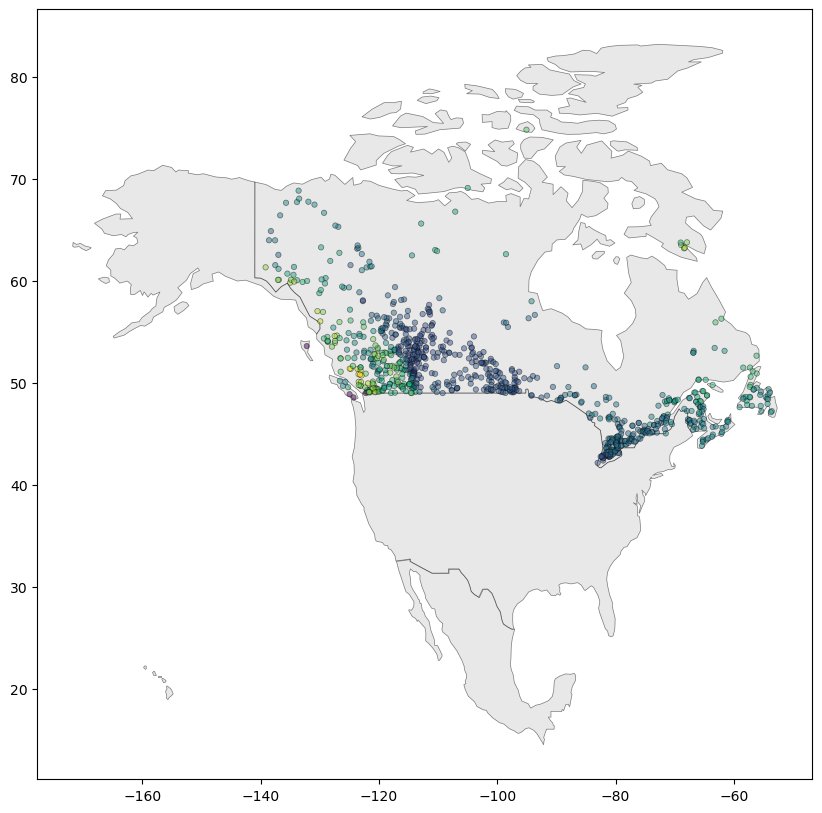

In [5]:
#visualize spatial pattern

saveIt = 0

fig, ax = plt.subplots(figsize = (10,10))

countries[countries["name"] == "Canada"].plot(color="lightgrey", ax = ax, aspect = None, alpha = 0.5, edgecolor = 'k', linewidth = 0.5)
countries[countries["name"] == "United States of America"].plot(color="lightgrey", ax = ax, aspect = None, alpha = 0.5, edgecolor = 'k', linewidth = 0.5)
countries[countries["name"] == "Mexico"].plot(color="lightgrey", ax = ax, aspect = None, alpha = 0.5, edgecolor = 'k', linewidth = 0.5)
ax.scatter(lon,lat, edgecolor = 'k', linewidth = 0.5, s = 15, alpha = 0.5, c = frac_snow)

if saveIt:
    plt.savefig('station_locations.png', dpi = 300, bbox_inches = 'tight')

plt.show()


# Calculate streamflow responses

In [7]:
#determine event characteristics and streamflow responses at all basins

T_percentiles_beta = np.array([40,60,80]) #lower percentile thresholds of event classes used for calculating beta 
N_T = len(T_percentiles_beta) #number of percentile thresholds
N_stations = len(dir_data_filenames) #number of stations in Canada

#initialize variables
beta_station_percentiles = np.zeros((N_stations,N_T,365)) #station x temperature event class x 365; 30-day rolling windows of beta = dQ / (Te*dte)
Q_rolling_all = np.zeros((N_stations,365)) #average 30-day streamflow
dQdT_hw_all = [[[] for kk in range(N_T)] for kk in range(N_stations)] #list of betas for all events ('heatwaves') for all event classes and stations
t_hw_all = [[[] for kk in range(N_T)] for kk in range(N_stations)] #list of day-of-year of onset of each event
hw_year_all = [[[] for kk in range(N_T)] for kk in range(N_stations)] #list of day-of-year of onset of each event
hwd_all = [[[] for kk in range(N_T)] for kk in range(N_stations)] #list of day-of-year of onset of each event
P_hw_all = [[[] for kk in range(N_T)] for kk in range(N_stations)] #list of total precip during each event
Pmean_hw_all = [[[] for kk in range(N_T)] for kk in range(N_stations)] #list of daily mean precip during each event
Tmean_hw_all = [[[] for kk in range(N_T)] for kk in range(N_stations)] #list of daily mean temp during each event
swe_hw_all = [[[] for kk in range(N_T)] for kk in range(N_stations)] #list of mean swe during each event

#calculate day of year integers for each day in the record (and day of water year integers); between 0 and 364
filename = dir_data_filenames[0]
df = pd.read_csv(filename)
day_of_year = np.array([pd.Period(date).day_of_year for date in df['date']])
day_of_year_wy = np.mod(day_of_year - 273, 365)

for kk_station in range(N_stations): #for each station
    
    if np.mod(kk_station,50) == 0: #print progress
        print(str(kk_station+1) + ' / ' + str(N_stations))

    filename = dir_data_filenames[kk_station] #filename of this station

    for kk_T, T_percentile in enumerate(T_percentiles_beta): #for each event class
        
        #calculate all characteristics
        dQdT_rolling, dQdT_hw, Q_rolling, Q_median, Tmean_hw, P_hw, Pmean_hw, swe_hw, t_hw, hw_year, hwd = heatwave_analysis(filename, T_percentile)
        beta_station_percentiles[kk_station,kk_T,:] = dQdT_rolling
        dQdT_hw_all[kk_station][kk_T] = dQdT_hw
        t_hw_all[kk_station][kk_T] = t_hw
        hw_year_all[kk_station][kk_T] = hw_year
        hwd_all[kk_station][kk_T] = hwd
        P_hw_all[kk_station][kk_T] = P_hw
        Pmean_hw_all[kk_station][kk_T] = Pmean_hw
        Tmean_hw_all[kk_station][kk_T] = Tmean_hw
        swe_hw_all[kk_station][kk_T] = swe_hw
    
    Q_rolling_all[kk_station,:] = Q_rolling
    
#normalize beta to have a max value of 1 at each station so their shapes can be compared to one another
beta_station_percentiles_norm = beta_station_percentiles / np.expand_dims(np.nanmax(beta_station_percentiles, axis = -1),axis = -1)

1 / 868
51 / 868
101 / 868
151 / 868
201 / 868
251 / 868
301 / 868
351 / 868
401 / 868
451 / 868
501 / 868
551 / 868
601 / 868
651 / 868
701 / 868
751 / 868
801 / 868
851 / 868


In [9]:
#now that event characteristics have been determined, calculate seasonal characteristics

N_stations = len(dir_data_filenames)
N_days = 14609

#initialize
Q = np.zeros((N_stations,N_days)) #stations x days; entire daily time series of streamflow observations
swe = np.zeros((N_stations,N_days)) #snow water equivalent
Tmean = np.zeros((N_stations,N_days)) #mean temp
P = np.zeros((N_stations,N_days)) #precip

for kk_station, filename in enumerate(dir_data_filenames): #for each station, load full met data time series

    ##### OPEN DATA

    df = pd.read_csv(filename)
    day_of_year = np.array([pd.Period(date).day_of_year for date in df['date']])
    day_of_year_wy = np.mod(day_of_year - 273, 365)
    df['day_of_year'] = day_of_year

    Q[kk_station,:] = df['streamflow'] #streamflow
    swe[kk_station,:] = df['snow_depth_water_equivalent_mean'] #swe
    Tmean[kk_station,:] = df['temperature_2m_mean'] #mean temp
    P[kk_station,:] = df['total_precipitation_sum'] #total precip

#extract years/months/days of each observation
date_years = np.array([pd.Period(date).year for date in df['date']])
date_months = np.array([pd.Period(date).month for date in df['date']])
date_days = np.array([pd.Period(date).day for date in df['date']])
    
#calculate fraction of precip that falls as snow
Psnow = np.copy(P)
Prain = np.copy(P)
Psnow[Tmean>0] = 0
Prain[Tmean<0] = 0
P_total = np.nansum(P, axis = 1)
Psnow_total = np.nansum(Psnow, axis = 1)
Prain_total = np.nansum(Prain, axis = 1)
fsnow = Psnow_total / P_total
frain = Prain_total / P_total

#calculate seasonality of precipitation and temperature
P_mean = np.zeros((N_stations,365)) #seasonal precip (no smoothing)
Tmean_mean = np.zeros((N_stations, 365)) #seasonal temp
Tmean_90 = np.zeros((N_stations,365)) #80th percentile of daily temp
Pmean_smooth = np.zeros((N_stations, 365)) #30-day smoothed seasonal precip
days_periodic = np.zeros(395, dtype = 'int') #for smoothing precip
days_periodic[:365] = np.arange(365, dtype = 'int')
days_periodic[365:] = np.arange(30, dtype = 'int')
for kk_station, filename in enumerate(dir_data_filenames): #for each station
    P_mean[kk_station,:] = np.array([np.nanmean(P[kk_station,day_of_year_wy==day]) for day in range(365)]) #mean precipitation of each day of the year at each station
    Tmean_mean[kk_station,:] = np.array([np.nanmean(Tmean[kk_station,day_of_year_wy==day]) for day in range(365)]) #mean temp of each day of the year at each station
    Tmean_90[kk_station,:] = np.array([np.nanpercentile(Tmean[kk_station,day_of_year_wy == dd], q = 80) for dd in range(365)]) #80th percentile of temperature for each day of the year
    Pmean_smooth[kk_station,:] = np.array([np.nanmean(P_mean[kk_station,days_periodic[day:day+30]]) for day in range(365)]) #30-day rolling mean of daily mean precip
    
Tmean_yearly_mean = np.nanmean(Tmean_mean,axis = 1)

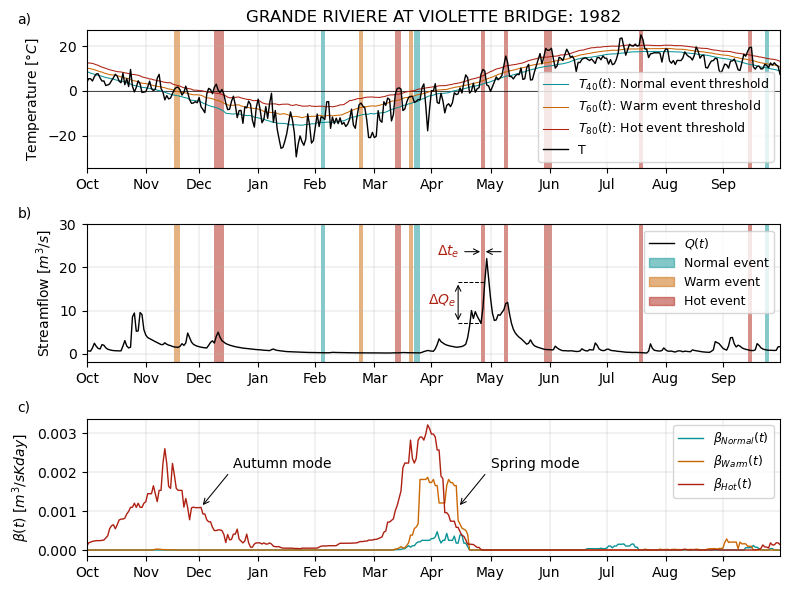

In [10]:
#visualize events, streamflow response, and aggregate sensitivity

saveIt = 0

fs = 12

kk_station = 0
event_classes = ['Normal', 'Warm', 'Hot']
colours = np.array([
    [10, 147, 150], #normal
    [202, 103, 2],  #warm
    [174, 32, 18]   #hot
])/255

#initialize
T40 = np.zeros(365) #40th temperature percentile
T60 = np.zeros(365) #60th temperature percentile
T80 = np.zeros(365) #80th temperature percentile

#calculate temperature percentiles from 15-day window
Tmean_range = [[] for kk in range(365)]
for day in range(365): #for each day
    
    #determine 15-days of interest (7 days before and after current day)
    if day<7:
        day_range = np.concatenate([np.arange(365 + day - 7,365), np.arange(0, day + 8)])
    elif day + 7 >= 365:
        day_range = np.concatenate([np.arange(day - 7, 365), np.arange(0, 7 - (364 - day))])
    else:
        day_range = np.arange(day - 7, day + 8)
    for kk, dd in enumerate(day_range):
        Tmean_range[day].extend(Tmean[kk_station,day_of_year == dd])

    #temp
    T40[day] = np.nanpercentile(Tmean_range[day], q = 40)
    T60[day] = np.nanpercentile(Tmean_range[day], q = 60)
    T80[day] = np.nanpercentile(Tmean_range[day], q = 80)

#determine days of one year for visualization
kk_year = 1
inds_this_year = np.arange((kk_year-1)*365,kk_year*365)+272
order = np.concatenate([np.arange(273,365),np.arange(273)])

##### make figure
nrows = 3
ncols = 1
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (8*ncols, 2*nrows))

lw = 0.75 #linewidth

##### plot temperature and label events
ax = axes[0]
ax.plot([0,364],[0,0], 'k', linewidth = 0.5) #0C
ax.plot(T40[order], label = '$T_{40}(t)$: Normal event threshold', color = colours[0], linewidth = lw)
ax.plot(T60[order], label = '$T_{60}(t)$: Warm event threshold', color = colours[1], linewidth = lw)
ax.plot(T80[order], label = '$T_{80}(t)$: Hot event threshold', color = colours[2], linewidth = lw)
ax.plot(Tmean[kk_station,inds_this_year], 'k', linewidth = 1, label = 'T')

##### plot events for temperature and streamflow timeseries
for ax in axes[:2]: #for temp and streamflow timeseries

    for kk_T in range(3): #for each event class

        ii = 0 #count for labelling

        #indices of events in this year
        inds_this_year_hw = np.argwhere(
            (hw_year_all[kk_station][kk_T] == years[kk_year]) | 
            (hw_year_all[kk_station][kk_T] == years[kk_year]-1)
        ).squeeze()

        x = np.zeros((1,1,3))
        x[0,0,:] = colours[kk_T]

        for kk_hw in range(len(t_hw_all[kk_station][kk_T][inds_this_year_hw])): #for each event

            condition1 = (t_hw_all[kk_station][kk_T][inds_this_year_hw[kk_hw]] < 92) & (hw_year_all[kk_station][kk_T][inds_this_year_hw[kk_hw]] == years[kk_year]-1) #if Oct/Nov/Dec of prior calendar year
            condition2 = (t_hw_all[kk_station][kk_T][inds_this_year_hw[kk_hw]] >= 92) & (hw_year_all[kk_station][kk_T][inds_this_year_hw[kk_hw]] == years[kk_year]) #if Jan onwards of chosen calendar year

            if condition1 | condition2:

                left = t_hw_all[kk_station][kk_T][inds_this_year_hw[kk_hw]]
                right = t_hw_all[kk_station][kk_T][inds_this_year_hw[kk_hw]] + hwd_all[kk_station][kk_T][inds_this_year_hw[kk_hw]] - 1

                extent = [left,right,-35,30]

                if ii == 0: #label first event of this class
                    ax.imshow(x,extent = extent, aspect = 'auto', alpha = 0.5, label = event_classes[kk_T] + ' event')
                    ii=1
                else:
                    ax.imshow(x,extent = extent, aspect = 'auto', alpha = 0.5)

##### plot streamflow and label events
ax = axes[1]
ax.plot(Q[kk_station,inds_this_year], color = 'k', label = '$Q(t)$', linewidth = 1)
for kk_T in range(3):
    ax.fill_between(x = [-100,-99], y1 = [0,0], y2 = [1,1], color = colours[kk_T], alpha = 0.5, label = event_classes[kk_T] + ' event')


##### plot betas
ax = axes[2]
for kk_T in range(3):
    ax.plot(beta_station_percentiles[kk_station,kk_T,:], color = colours[kk_T], label = '$\u03B2 _{' + event_classes[kk_T] + '}(t)$', linewidth = 1)
    
##### formatting
for kk_ax, ax in enumerate(axes):
    axes_dates(ax)
    ax.grid(True,linewidth = 0.25)
    ax.set_axisbelow(True)
    ax.legend(ncol=1, fontsize = 9)
    ax.text(x = -0.1, y = 1.05, s = abc[kk_ax], transform = ax.transAxes, fontsize = fs-2)
    
axes[0].set_ylim(bottom = np.nanmin(Tmean[kk_station,inds_this_year])-5, top = np.nanmax(Tmean[kk_station,inds_this_year])+2)
axes[1].set_ylim(bottom = -2)

axes[0].set_ylabel('Temperature [$\degree C$]')
axes[1].set_ylabel('Streamflow [$m^3/s$]')
axes[2].set_ylabel('$\u03B2 (t)$ [$m^3/s K day$]')
axes[0].set_title(station_names[kk_station] + ': ' + str(years[kk_year]))

##### annotate
kk_hw = 9
kk_T = 2
inds_this_year_hw = np.argwhere(
    (hw_year_all[kk_station][kk_T] == years[kk_year]) | 
    (hw_year_all[kk_station][kk_T] == years[kk_year]-1)
).squeeze()
left = t_hw_all[kk_station][kk_T][inds_this_year_hw[kk_hw]]
right = t_hw_all[kk_station][kk_T][inds_this_year_hw[kk_hw]] + hwd_all[kk_station][kk_T][inds_this_year_hw[kk_hw]] - 1
ax = axes[1]

#black dashed lines for dQ 
y1 = Q[kk_station,inds_this_year][int(left)]
ax.plot([left-12,left],[y1,y1], 'k--', linewidth = 0.75)
y2 = Q[kk_station,inds_this_year][int(right)]
ax.plot([left-12,right],[y2,y2], 'k--', linewidth = 0.75)

#dQ
ax.annotate('', xy = (left-12,y1), xytext = (left-12,y2), arrowprops=dict(arrowstyle="<->", linewidth = 0.75))
ax.text(x = left - 28, y = np.mean([y1,y2])-0.5, s = '$\Delta Q_e$', color = colours[kk_T])

#arrows and text for dt
ax.annotate('', xy = (left-10,y2+7), xytext = (left+1,y2+7), arrowprops=dict(arrowstyle="<-", linewidth = 0.75))
ax.annotate('', xy = (right-1,y2+7), xytext = (right + 10,y2+7), arrowprops=dict(arrowstyle="->", linewidth = 0.75))
ax.text(x = left-23, y = y2+6, s = '$\Delta t_e$', color = colours[kk_T])

#autumn and spring mode text
ax = axes[-1]
ax.annotate('', xy = (75,2e-3), xytext = (60,1.1e-3), arrowprops=dict(arrowstyle="<-", linewidth = 0.75))
ax.text(x = 77, y = 2.1e-3, s = 'Autumn mode')
ax.annotate('', xy = (210,2e-3), xytext = (195,1.1e-3), arrowprops=dict(arrowstyle="<-", linewidth = 0.75))
ax.text(x = 212, y = 2.1e-3, s = 'Spring mode')

plt.tight_layout()

if saveIt:
    plt.savefig('Figures/example_one_year.png', dpi = 400, bbox_inches = 'tight')

plt.show()

In [11]:
# # FOR CMOS PRESENTATION

# saveIt = 0

# fig, ax = plt.subplots(figsize = (6,3))

# leap_adjust = 0
# for kk_year in range(40):
#     if np.mod(kk_year,4)==0:
#         leap_adjust += 1 
#     inds_this_year = np.arange((kk_year-1)*365,kk_year*365)+272 + leap_adjust
#     ax.plot(Tmean[kk_station,inds_this_year], 'k', linewidth = 0.011)

# # ax.plot(T40[order], color = colours[0], linewidth = 2, label = '40th percentile')
# # ax.plot(T60[order], color = colours[1], linewidth = 2, label = '60th percentile')
# # ax.plot(T80[order], color = colours[2], linewidth = 2, label = '80th percentile')

# axes_dates(ax)
# ax.set_ylim(bottom = -27, top = 26)
# ax.set_ylabel('Temperature [$\degree$C]')
# # ax.legend(loc = 'lower right')

# if saveIt:
#     plt.savefig('Figures/Supplementary/temp_thresholds0_cmos.png', dpi = 300, bbox_inches = 'tight')

# plt.show()

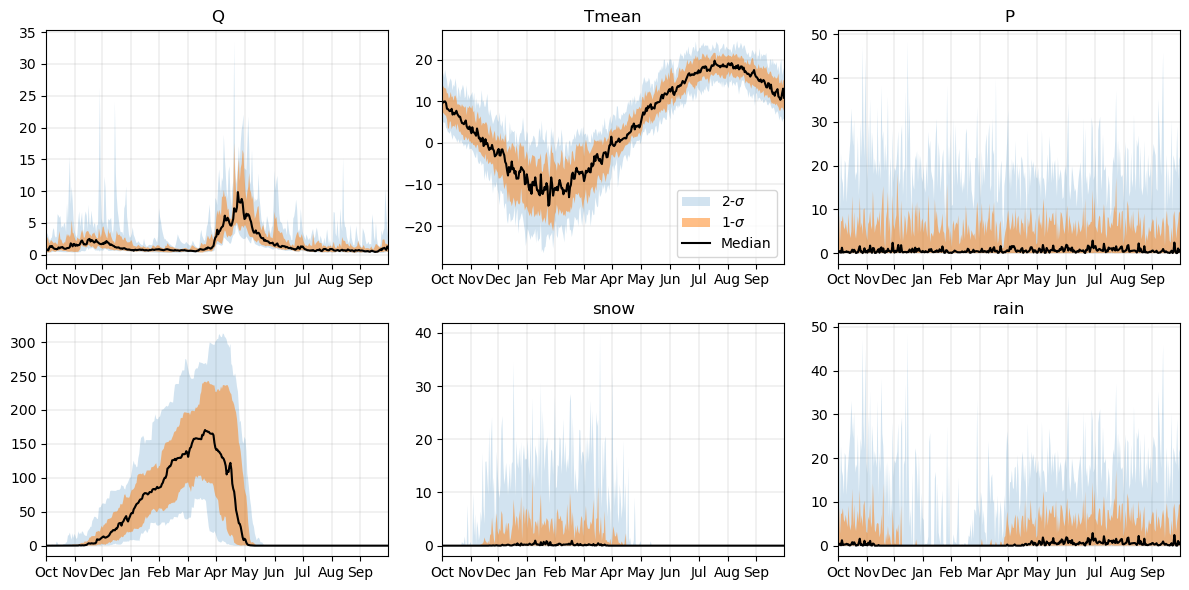

In [12]:
#visualize climate summary of one station

saveIt = 0

kk_station = 10

#variables to plot
vars = [Q[kk_station,:], 
        Tmean[kk_station,:], 
        P[kk_station,:], 
        swe[kk_station,:],
        Psnow[kk_station,:],
        Prain[kk_station,:]
       ]
varnames = ['Q','Tmean','P','swe','snow','rain']

ncols = 3
nrows = 2

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 3*nrows))

for kk_var, ax in enumerate(axes.flatten()): #for each axis and variable
    
    var = vars[kk_var]
    
    #2-sigma
    y1 = np.array([np.nanpercentile(var[day_of_year_wy==day], q = 2.5) for day in range(365)])
    y2 = np.array([np.nanpercentile(var[day_of_year_wy==day], q = 97.5) for day in range(365)])
    ax.fill_between(x = np.arange(365), y1 = y1, y2 = y2, alpha = 0.2, label = '2-$\sigma$')

    #1-sigma
    y1 = np.array([np.nanpercentile(var[day_of_year_wy==day], q = 16) for day in range(365)])
    y2 = np.array([np.nanpercentile(var[day_of_year_wy==day], q = 84) for day in range(365)])
    ax.fill_between(x = np.arange(365), y1 = y1, y2 = y2, alpha = 0.5, label = '1-$\sigma$')
    
    #median
    y1 = np.array([np.nanpercentile(var[day_of_year_wy==day], q = 50) for day in range(365)])
    ax.plot(y1,'k', label = 'Median')
    
    ax.set_title(varnames[kk_var])
    
axes[0,1].legend(loc = 'lower right')

for ax in axes.flatten():
    ax.set_xlim(left = 0,right = 364)
    ax.grid(True, linewidth = 0.25)
    ax.set_axisbelow(True)
    ax.set_xticks(first_days_of_month)
    ax.set_xticklabels(months_str, rotation = 0)

plt.tight_layout()

if saveIt:
    plt.savefig('weather_one_station.png', bbox_inches = 'tight', dpi = 400)

plt.show()

In [14]:
#calculate event qualities using rolling 30-day windows

#initialize
N_percentile_bins = len(T_percentiles_beta)
Tmean_hw_rolling = np.zeros((N_stations,N_percentile_bins,365))
Pmean_hw_rolling = np.zeros((N_stations,N_percentile_bins,365))
swe_hw_rolling = np.zeros((N_stations,N_percentile_bins,365))
N_all_hw = np.zeros((N_stations,N_percentile_bins,365))

bin_width = 30

for kk_station in range(N_stations): #for each station
    
    for kk_T in range(3): #for each event class

        for day_start in range(0,365): #for each day of year

            #determine days of the window
            if day_start < 335:
                inds_bin_all = np.argwhere(
                    (t_hw_all[kk_station][kk_T] >= day_start) & 
                    (t_hw_all[kk_station][kk_T] < day_start + bin_width)
                ).squeeze()
            else:
                N_rollover_days = 30 - (365 - day_start)
                inds_bin_all = np.argwhere(
                    (t_hw_all[kk_station][kk_T] >= day_start) | 
                    (t_hw_all[kk_station][kk_T] < N_rollover_days)
                ).squeeze()
            
            #calculate median temp/precip/swe
            N_all_hw[kk_station,kk_T,day_start] = np.size(inds_bin_all)
            if N_all_hw[kk_station,kk_T,day_start] > 0:
                Tmean_hw_rolling[kk_station,kk_T,day_start] = np.nanmedian(Tmean_hw_all[kk_station][kk_T][inds_bin_all])
                Pmean_hw_rolling[kk_station,kk_T,day_start] = np.nanmedian(Pmean_hw_all[kk_station][kk_T][inds_bin_all])
                swe_hw_rolling[kk_station,kk_T,day_start] = np.nanmedian(swe_hw_all[kk_station][kk_T][inds_bin_all])
            else:    
                Tmean_hw_rolling[kk_station,kk_T,day_start] = np.nan
                Pmean_hw_rolling[kk_station,kk_T,day_start] = np.nan
                swe_hw_rolling[kk_station,kk_T,day_start] = np.nan

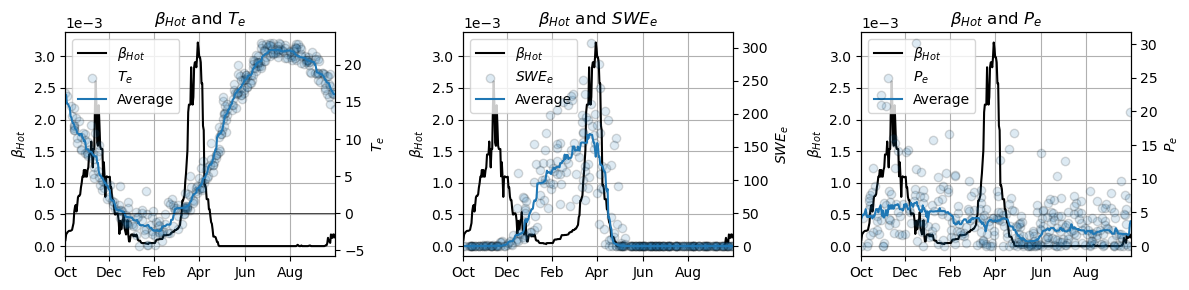

In [75]:
#visualize beta with temp, precip, and swe for a single basin

saveIt = 0

kk_station = 0

ncols = 3
nrows = 1

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (12,3))

tt = np.arange(365)
order = np.zeros(365, dtype = 'int')
order[:15] = np.arange(350,365)
order[15:] = np.arange(350)

#temp
ax = axes[0]
ax.plot(beta_station_percentiles[kk_station,-1,:], 'k', label = '$\u03B2_{Hot}$')
ax2 = ax.twinx()
ax2.scatter(t_hw_all[kk_station][-1],Tmean_hw_all[kk_station][-1], edgecolor = 'k', alpha = 0.15, label = '$T_{e}$')
ax2.plot(tt,Tmean_hw_rolling[kk_station,-1,order], label = 'Average')
ax2.plot([0,365],[0,0], 'k', linewidth = 0.5)
ax2.set_ylabel('$T_{e}$')
ax.set_title('$\u03B2_{Hot}$ and $T_{e}$')

#swe
ax = axes[1]
ax.plot(beta_station_percentiles[kk_station,-1,:], 'k', label = '$\u03B2_{Hot}$')
ax3 = ax.twinx()
ax3.scatter(t_hw_all[kk_station][-1],swe_hw_all[kk_station][-1], edgecolor = 'k', alpha = 0.15, label = '$SWE_{e}$')
ax3.plot(tt,swe_hw_rolling[kk_station,-1,order], label = 'Average')
ax3.set_ylabel('$SWE_{e}$')
ax.set_title('$\u03B2_{Hot}$ and $SWE_{e}$')

#precip
ax = axes[2]
ax.plot(beta_station_percentiles[kk_station,-1,:], 'k', label = '$\u03B2_{Hot}$')
ax4 = ax.twinx()
ax4.scatter(t_hw_all[kk_station][-1],Pmean_hw_all[kk_station][-1], edgecolor = 'k', alpha = 0.15, label = '$P_{e}$')
ax4.plot(tt,Pmean_hw_rolling[kk_station,-1,order], label = 'Average')
ax4.set_ylabel('$P_{e}$')
ax.set_title('$\u03B2_{Hot}$ and $P_{e}$')

#legend
axes_weather = [ax2,ax3,ax4]
for kk_ax, ax in enumerate(axes):
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = axes_weather[kk_ax].get_legend_handles_labels()
    labels = l1+l2
    handles = h1+h2
    ax.legend(handles, labels, loc = 'upper left')

#formatting
for ax in axes:
    ax.set_xlim(left = 0,right = 364)
    ax.grid(True)
    ax.set_axisbelow(True)
    ax.set_xticks(first_days_of_month[::2])
    ax.set_xticklabels(months_str[::2], rotation = 0)
    ax.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0.001))
    ax.set_ylabel('$\u03B2_{Hot}$')

plt.tight_layout()

if saveIt:
    plt.savefig('Figures/Supplementary/beta_and_event_weather.png', dpi = 300, bbox_inches = 'tight')

# Sine temperature models: $t_+$, $t_-$, and $\Delta$

In [48]:
#fit sine curves to percentile levels of temperature for each station

T_percentiles = np.array([50,55,60,65,70,75,80,85,90,95,99]) #percentile levels
N_T = len(T_percentiles) #number of percentile levels
N_percentile_bins = len(T_percentiles_beta)

dtp_dT0 = np.zeros((N_stations, N_T)) #T>0 transition timing sensitivity to warming mean annual temp
dtm_dT0 = np.zeros((N_stations, N_T)) #T<0 transition timing sensitivity to warming mean annual temp

tp = np.zeros((N_stations, N_T)) #T>0 transition timing
tm = np.zeros((N_stations, N_T)) #T<0 transition timing

omega = np.zeros((N_stations, N_T)) #frequency
T_amp = np.zeros((N_stations, N_T)) #amplitude
T_0 = np.zeros((N_stations, N_T))   #mean 
phi = np.zeros((N_stations, N_T))   #phase

Tm = np.zeros(N_stations) #melt temperature: set to 0C

for kk_station in range(N_stations): #for each station
    
    if np.mod(kk_station,50) == 0: #print progress
        print(str(kk_station) + ' / ' + str(N_stations))
 
    for kk_T, T_percentile in enumerate(T_percentiles): #for each percentile level

        tt = np.arange(365) #time
        yy = np.array([np.nanpercentile(Tmean[kk_station,(day_of_year_wy == day)], q = T_percentile) for day in range(365)]) #temperature of this percentile level

        #fit sinusoid to temperature of this percentile
        res = fit_sin(tt, yy)
        yy_sine = res['fitfunc'](tt)

        omega[kk_station,kk_T] = res['omega']
        T_amp[kk_station,kk_T] = np.abs(res['amp'])
        T_0[kk_station,kk_T] = res['offset']
        phi[kk_station,kk_T] = -res['phase']

        #calculate transition timings
        tp[kk_station,kk_T] = (1 / omega[kk_station,kk_T]) * (np.pi + phi[kk_station,kk_T] - np.arcsin((T_0[kk_station,kk_T] - Tm[kk_station])/T_amp[kk_station,kk_T]))
        tm[kk_station,kk_T] = (1 / omega[kk_station,kk_T]) * (phi[kk_station,kk_T] + np.arcsin((T_0[kk_station,kk_T] - Tm[kk_station])/T_amp[kk_station,kk_T]))

        #calculate sensitivity of transition timings
        dtp_dT0[kk_station,kk_T] = - (1 / (omega[kk_station,kk_T]*T_amp[kk_station,kk_T])) * ( 1 / np.sqrt(1 - ((T_0[kk_station,kk_T] - Tm[kk_station])/T_amp[kk_station,kk_T])**2) )
        dtm_dT0[kk_station,kk_T] =   (1 / (omega[kk_station,kk_T]*T_amp[kk_station,kk_T])) * ( 1 / np.sqrt(1 - ((T_0[kk_station,kk_T] - Tm[kk_station])/T_amp[kk_station,kk_T])**2) )
 
t_below_0 = tp - tm #duration below freezing of each station and percentile level

0 / 868
50 / 868
100 / 868
150 / 868
200 / 868
250 / 868
300 / 868
350 / 868
400 / 868
450 / 868
500 / 868
550 / 868
600 / 868
650 / 868
700 / 868
750 / 868
800 / 868
850 / 868


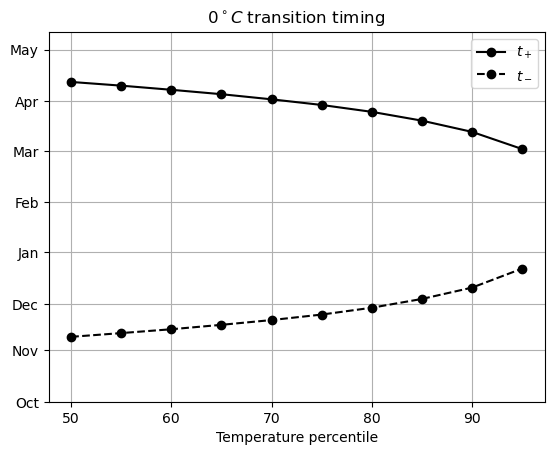

In [49]:
#visualize 0C transition timing by percentile for a single basin

kk_station = 0

fig, ax = plt.subplots()

ax.plot(T_percentiles,tp[kk_station,:], 'ko-', label = '$t_+$')
ax.plot(T_percentiles,tm[kk_station,:], 'ko--', label = '$t_-$')

ax.set_title('$0^\circ C$ transition timing')
ax.set_xlabel('Temperature percentile')
ax.set_yticks(first_days_of_month)
ax.set_yticklabels(months_str)
ax.set_ylim(top = tp[0,0] + 30)
ax.grid(True)
ax.set_axisbelow(True)
ax.legend()

plt.show()

# How are beta and temperature metrics related?

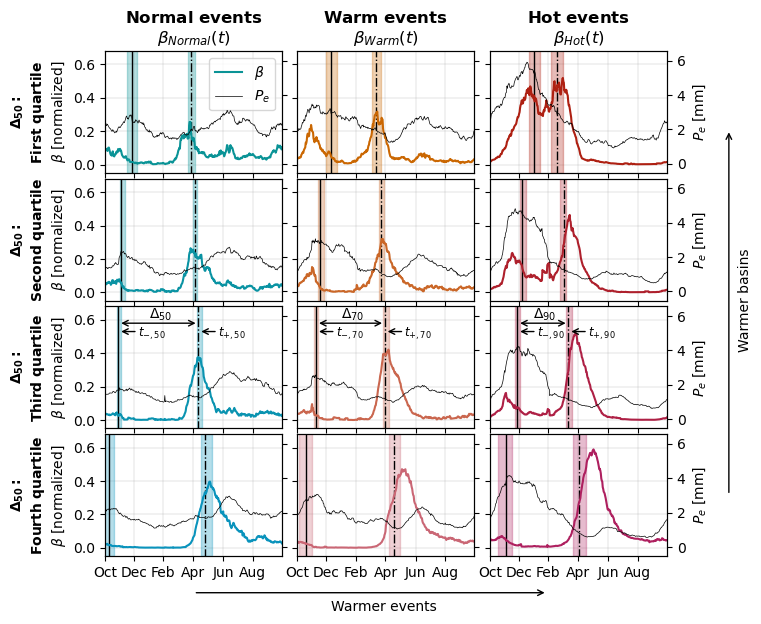

In [50]:
#visualize beta, aggregated by climate (t_below_0) and temperature event class

saveIt = 0

#colours of normal, warm, and hot event classes
colours = np.array([
    [10, 147, 150],
    [202, 103, 2],
    [174, 32, 18]
])/255

blue_scale = [1,3,2] #scaling factor used to increase blue for colder climates

nrows = 4
ncols = 3

# kk_T = np.argwhere(T_percentiles == 80)[0][0]
kk_Ts = [0,4,8]

title_parts = ['Normal', 'Warm', 'Hot']
labels = [r'$\bf{\Delta_{50}}:$' + '\n' + r'$\bf{First}$' + ' ' + r'$\bf{quartile}$',
          r'$\bf{\Delta_{50}}:$' + '\n' + r'$\bf{Second}$' + ' ' + r'$\bf{quartile}$',
          r'$\bf{\Delta_{50}}:$' + '\n' + r'$\bf{Third}$' + ' ' + r'$\bf{quartile}$',
          r'$\bf{\Delta_{50}}:$' + '\n' + r'$\bf{Fourth}$' + ' ' + r'$\bf{quartile}$']

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (2.5*ncols, 1.5*nrows))

for kk_T in range(3): #for each event class
    
    #calculate indices of stations to aggregate in each row: split stations by quartile of delta50
    p0 = np.nanpercentile(t_below_0[:,0], q = 25)
    p1 = np.nanpercentile(t_below_0[:,0], q = 50)
    p2 = np.nanpercentile(t_below_0[:,0], q = 75)
    
    inds0 = np.argwhere(t_below_0[:,0] < p0).squeeze()
    inds1 = np.argwhere((t_below_0[:,0] < p1) & (t_below_0[:,0] > p0)).squeeze()
    inds2 = np.argwhere((t_below_0[:,0] < p2) & (t_below_0[:,0] > p1)).squeeze()
    inds3 = np.argwhere(t_below_0[:,0] > p2).squeeze()

    inds_set = [inds0,inds1,inds2,inds3]

    for kk_delta in range(4): #for each row (set of stations belonging to a quartile of delta)

        ax = axes[kk_delta,kk_T]

        ##### PLOT PRECIP
        ax_precip = ax.twinx()
        ax_precip.plot(np.nanmean(Pmean_hw_rolling[inds_set[kk_delta],kk_T,:], axis = 0), color = 'k', linewidth = 0.5)
        ax_precip.set_ylim(bottom = -7/13, top = 6.56) #scale so that 0s line up on both y axes
        
        if kk_T < 2:
            ax_precip.set_yticklabels([])
        else:
            ax_precip.set_ylabel('$P_e$ [mm]')
        #####
        
        ##### PLOT TIMING       
        t1 = np.nanpercentile(tm[inds_set[kk_delta],kk_Ts[kk_T]], q = 50) #median
        t2 = np.nanpercentile(tm[inds_set[kk_delta],kk_Ts[kk_T]], q = 16) #one standard deviation
        t3 = np.nanpercentile(tm[inds_set[kk_delta],kk_Ts[kk_T]], q = 84) #one standard deviation

        t4 = np.nanpercentile(tp[inds_set[kk_delta],kk_Ts[kk_T]], q = 50) #median
        t5 = np.nanpercentile(tp[inds_set[kk_delta],kk_Ts[kk_T]], q = 16) #one standard deviation
        t6 = np.nanpercentile(tp[inds_set[kk_delta],kk_Ts[kk_T]], q = 84) #one standard deviation

        y1 = [0.7,0.7]
        y2 = [-.05,-.05]

        color = colours[kk_T] + np.array([0,0,0.05*kk_delta*blue_scale[kk_T]])

        ax.fill_between(x = [t2,t3], y1 = y1, y2 = y2, alpha = 0.3, color = color) #shaded box for tm
        ax.fill_between(x = [t5,t6], y1 = y1, y2 = y2, alpha = 0.3, color = color) #shaded box for tp

        ax.plot([t1,t1], [y1[0],y2[0]], color = 'k', linewidth = 1) #median for tm
        ax.plot([t4,t4], [y1[0],y2[0]], color = 'k', linewidth = 1, linestyle = '-.') #median for tp
        #####

        ##### PLOT BETA
        var = beta_station_percentiles_norm[:,kk_T,:]
        x1 = np.nanmean(var[inds_set[kk_delta],:], axis = 0)
        ax.plot(x1, color = color, label = '$\u03B2$')

        ax.set_xlim(left = 0, right = 365)
        ax.set_ylim(bottom = -0.05, top = 0.68)
        #####

        ##### FORMATTING / TEXT
        axes_dates(ax)
        ax.set_xticks(ax.get_xticks()[::2])
        
        if kk_delta < 3:
            ax.set_xticklabels([])
        if kk_T > 0:
            ax.set_yticklabels([])
        if kk_delta == 0:
            ax.set_title(r'$\bf{' + title_parts[kk_T] + '}$' + ' ' + r'$\bf{events}$' + '\n$\u03B2_{' + title_parts[kk_T] + '}(t)$')
        if kk_T == 0:
            ax.set_ylabel(labels[kk_delta] + '\n$\u03B2$ [normalized]')
            if kk_delta == 0:
                ax.plot([100,101],[100,101],'k', linewidth = 0.5, label = '$P_e$')
                ax.legend(fontsize = 10)
        if kk_delta == 2:
            ax.text(x = t1 + 40, y = 0.5, s = '$t_{-,' + str(T_percentiles[kk_Ts[kk_T]]) + '}$', fontsize = 8.5)
            ax.text(x = t4 + 40, y = 0.5, s = '$t_{+,' + str(T_percentiles[kk_Ts[kk_T]]) + '}$', fontsize = 8.5)
            ax.text(x = (t1+t4)/2-20, y = 0.61, s = '$\Delta_{' + str(T_percentiles[kk_Ts[kk_T]]) + '}$')
            ax.annotate(text = '', xy = (t1+40,0.53), xytext = (t1,0.53), arrowprops=dict(arrowstyle="<-"))
            ax.annotate(text = '', xy = (t4+40,0.53), xytext = (t4,0.53), arrowprops=dict(arrowstyle="<-"))
            ax.annotate(text = '', xy = (t1,0.58), xytext = (t4,0.58), arrowprops=dict(arrowstyle="<->"))        
        #####
    
plt.tight_layout(h_pad = -0.1, w_pad = -0.1)

axes[-1,-1].annotate(text = '', xy = (1.35,0.5), xytext = (1.35,3.5), arrowprops=dict(arrowstyle="<-"), xycoords='axes fraction')  
axes[-1,-1].text(x = 1.4, y = 1.7, s = 'Warmer basins', transform=ax.transAxes, rotation = 90)

axes[-1,0].annotate(text = '', xy = (0.5,-0.3), xytext = (2.5,-0.3), arrowprops=dict(arrowstyle="<-"), xycoords='axes fraction')  
axes[-1,0].text(x = -0.9, y = -0.45, s = 'Warmer events', transform=ax.transAxes)

if saveIt:
    plt.savefig('Figures/beta_with_timing_and_precip4.png', bbox_inches = 'tight', dpi = 300)
    
plt.show()

In [51]:
# # FOR CMOS CONFERENCE PRESENTATION

# saveIt = 0

# colours = np.array([
#     [10, 147, 150],
#     [202, 103, 2],
#     [174, 32, 18]
# ])/255

# blue_scale = [1,3,2]

# nrows = 1
# ncols = 3

# kk_T = np.argwhere(T_percentiles == 80)[0][0]
# kk_T_start = np.argwhere(T_percentiles == 80)[0][0]
# kk_T_end = np.argwhere(T_percentiles == 95)[0][0]+1

# kk_T_start = [np.argwhere(T_percentiles == 50)[0][0], np.argwhere(T_percentiles == 60)[0][0], np.argwhere(T_percentiles == 80)[0][0]]
# kk_T_end = [np.argwhere(T_percentiles == 55)[0][0]+1, np.argwhere(T_percentiles == 75)[0][0]+1, np.argwhere(T_percentiles == 95)[0][0]-1]

# kk_Ts = [0,4,8]

# title_parts = ['Normal', 'Warm', 'Hot']
# labels = [r'$\bf{\Delta_{50}}:$' + '\n' + r'$\bf{First}$' + ' ' + r'$\bf{quartile}$',
#           r'$\bf{\Delta_{50}}:$' + '\n' + r'$\bf{Second}$' + ' ' + r'$\bf{quartile}$',
#           r'$\bf{\Delta_{50}}:$' + '\n' + r'$\bf{Third}$' + ' ' + r'$\bf{quartile}$',
#           r'$\bf{\Delta_{50}}:$' + '\n' + r'$\bf{Fourth}$' + ' ' + r'$\bf{quartile}$']

# fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (3*ncols, 2.5*nrows))

# for kk_T in range(3):
    
#     ## HERE: no data threshold, binned by delta
#     p0 = np.nanpercentile(t_below_0[:,kk_T*3], q = 25)
#     p1 = np.nanpercentile(t_below_0[:,kk_T*3], q = 50)    
#     p2 = np.nanpercentile(t_below_0[:,kk_T*3], q = 75)
    
#     inds0 = np.argwhere(t_below_0[:,kk_T*3] < p0).squeeze()
#     inds1 = np.argwhere((t_below_0[:,kk_T*3] < p1) & (t_below_0[:,kk_T*3] > p0)).squeeze()
#     inds2 = np.argwhere((t_below_0[:,kk_T*3] < p2) & (t_below_0[:,kk_T*3] > p1)).squeeze()
#     inds3 = np.argwhere(t_below_0[:,kk_T*3] > p2).squeeze()
    
#     # inds0 = np.argwhere(t_below_0[:,kk_T*3] < p0).squeeze()
#     inds1 = np.argwhere((t_below_0[:,kk_T*3] < p1)).squeeze()# & (t_below_0[:,kk_T*3] > p0)).squeeze()
#     # inds2 = np.argwhere((t_below_0[:,kk_T*3] < p2) & (t_below_0[:,kk_T*3] > p1)).squeeze()
#     inds2 = np.argwhere(t_below_0[:,kk_T*3] > p1).squeeze()
    
#     inds1 = np.argsort(t_below_0[:,kk_T*3]).squeeze()[150:300]

#     inds_set = [inds0,inds1,inds2,inds3]
#     inds_set = [inds1]

#     for kk_delta in range(len(inds_set)):

#         ax = axes[kk_T]
        
#         color = colours[kk_T] + np.array([0,0,0.05*kk_delta*blue_scale[kk_T]])

#         ##### PLOT BETA
#         var = beta_station_percentiles_norm[:,kk_T,:]
#         x1 = np.nanmean(var[inds_set[kk_delta],:], axis = 0)
#         ax.plot(x1, color = color, label = '$\u03B2$')#, linewidth = 1)#, color = 'k', linestyle = linestyles[kk_T])

#         ax.set_xlim(left = 0, right = 365)
#         ax.set_ylim(bottom = -0.05, top = 0.62)
#         #####

#         ##### FORMATTING / TEXT
#         axes_dates(ax)
#         ax.set_xticks(ax.get_xticks()[::2])
        
#         # if kk_delta < 3:
#         #     ax.set_xticklabels([])
#         if kk_T > 0:
#             ax.set_yticklabels([])
#         if kk_delta == 0:
#             ax.set_title(r'$\bf{' + title_parts[kk_T] + '}$' + ' ' + r'$\bf{events}$' + '\n$\u03B2_{' + title_parts[kk_T] + '}(t)$')
#         if kk_T == 0:
#             ax.set_ylabel('$\u03B2$ [normalized]')
#             if kk_delta == 0:
#                 ax.plot([100,101],[100,101],'k', linewidth = 0.5, label = '$P_e$')
#                 # ax.legend(fontsize = 10)
#         if (kk_T <= 2) & (kk_delta == 2):
#             # ax.text(x = t1 - 65, y = 0.45, s = '$t_-$')
#             ax.text(x = t1 + 40, y = 0.5, s = '$t_{-,' + str(T_percentiles[kk_Ts[kk_T]]) + '}$', fontsize = 8.5)
#             ax.text(x = t4 + 40, y = 0.5, s = '$t_{+,' + str(T_percentiles[kk_Ts[kk_T]]) + '}$', fontsize = 8.5)
#             ax.text(x = (t1+t4)/2-20, y = 0.61, s = '$\Delta_{' + str(T_percentiles[kk_Ts[kk_T]]) + '}$')
#             # ax.annotate(text = '', xy = (t1-40,0.48), xytext = (t1,0.48), arrowprops=dict(arrowstyle="<-"))
#             ax.annotate(text = '', xy = (t1+40,0.53), xytext = (t1,0.53), arrowprops=dict(arrowstyle="<-"))
#             ax.annotate(text = '', xy = (t4+40,0.53), xytext = (t4,0.53), arrowprops=dict(arrowstyle="<-"))
#             ax.annotate(text = '', xy = (t1,0.58), xytext = (t4,0.58), arrowprops=dict(arrowstyle="<->"))        
#         #####
    
# plt.tight_layout()#h_pad = -0.1, w_pad = -0.1)

# if saveIt:
#     plt.savefig('Figures/beta_with_timing_and_precip4_CMOS.png', bbox_inches = 'tight', dpi = 400)
    
# plt.show()

In [52]:
Ts = T_percentiles

0.9025641025641026
0.5240715268225584
0.9383116883116883
0.6375838926174496
0.9514018691588785
0.8770270270270271


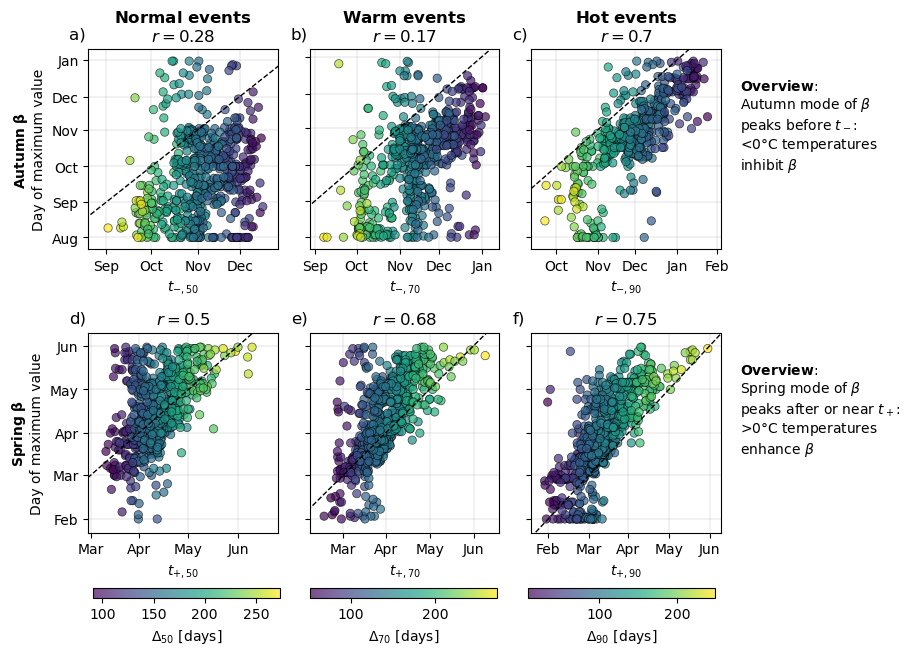

In [53]:
#visualize relationship between autumn/spring beta peaks, and 0C transition timings

saveIt = 0

fs = 12

nrows = 2
ncols = 3

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (2.5*ncols, 3*nrows))

# kk_spring = 90
# kk_spring = 150
kk_spring = 120
kk_winter = 90
kk_abc = 0

#formatting
for kk_row in range(2): #for autumn and spring modes
    for kk_T in range(3): #for each event class
       
        ax = axes[kk_row,kk_T]
        ax.grid(True, linewidth = 0.25)
        ax.set_axisbelow(True)
        ax.set_xticks(first_days_of_month_periodic)
        ax.set_xticklabels(months_str_periodic, rotation = 0)
        ax.set_yticks(first_days_of_month_periodic)
        
        if kk_T == 0:
            ax.set_yticklabels(months_str_periodic, rotation = 0)
        else:
            ax.set_yticklabels([])
        ax.plot([-60,400],[-60,400],'k--', linewidth = 1)
        # ax.plot([-60,kk_winter],[-60,kk_winter],'k--')
        
        ax.text(x = -0.1, y = 1.05, s = abc[kk_abc], transform = ax.transAxes, fontsize = fs)
        kk_abc+=1

for kk_T in range(3): #for each event class

    if kk_T == 0:
        kk_tp = 0 #index of 50th percentile
    elif kk_T == 1:
        kk_tp = 4 #index of 70th percentile
    elif kk_T == 2:
        kk_tp = 8 #index of 90th percentile

    a = np.zeros(N_stations)
    b = np.zeros(N_stations)
    c = np.zeros(N_stations)
    for kk_station in range(N_stations): #for each station
        x = beta_station_percentiles[kk_station,kk_T,kk_spring:243] #values during spring
        if np.nansum(x) > 0: #if not all nans and 0s
            a[kk_station] = np.nanargmax(x) #day of max value of spring beta mode
        else:
            a[kk_station] = np.nan
            
        winter_inds = np.concatenate([np.arange(90), np.arange(305,365)]) #august through december
        # y = beta_station_percentiles[kk_station,kk_T,:kk_winter]
        y = beta_station_percentiles[kk_station,kk_T,winter_inds]
        if np.nansum(y) > 0: #if not all nans and 0s
            b[kk_station] = np.nanargmax(y) #day of max value of autumn beta mode
            if b[kk_station] >= kk_winter: #adjust for DOY
                b[kk_station]-=(kk_winter+60)
        else:
            b[kk_station] = np.nan

    x1 = tm[:,kk_tp] #transition below 0C for (50th, 70th, or 90th) percentile of temperature 
    x2 = b #day of max value of autumn mode

    x3 = tp[:,kk_tp] #transition above 0C for (50th, 70th, or 90th) percentile of temperature 
    x4 = a + kk_spring #day of max value of spring mode
    
    c = t_below_0[:,kk_tp] #delta for (50th, 70th, or 90th) percentile of temperature 
    
    R2_autumn = np.corrcoef(x1[x1+x2>0],x2[x1+x2>0])[0,1]**2 #R squared b/w 0C transition and peak timing of autumn mode
    R2_spring = np.corrcoef(x3[x3+x4>0],x4[x3+x4>0])[0,1]**2 #R squared b/w 0C transition and peak timing of spring mode

    ax = axes[0,kk_T]
    s = ax.scatter(x1,x2, alpha = 0.7, edgecolor = 'k', linewidth = 0.5, c = c)
    ax.set_xlabel('$t_{-,' + str(Ts[kk_tp]) + '}$')
    ax.set_title(r'$\bf{' + title_parts[kk_T] + '}$' +  r' $\bf{events}$' + '\n$r=${}'.format(np.round(np.sqrt(R2_autumn), decimals = 2)))
    
    ax = axes[1,kk_T]
    s = ax.scatter(x3,x4, alpha = 0.7, edgecolor = 'k', linewidth = 0.5, c = c)
    ax.set_xlabel('$t_{+,' + str(Ts[kk_tp]) + '}$')
    ax.set_title('$r=${}'.format(np.round(np.sqrt(R2_spring), decimals = 2)))
    
    #format
    axes[0,kk_T].set_xlim(left = np.nanmin(x1)-10, right = np.nanmax(x1)+10)
    axes[1,kk_T].set_xlim(left = np.nanmin(x3)-10, right = np.nanmax(x3)+10)
    axes[0,kk_T].set_ylim(bottom = np.nanmin(x2)-10, top = np.nanmax(x2)+10)
    axes[1,kk_T].set_ylim(bottom = np.nanmin(x4)-10, top = np.nanmax(x4)+10)    
    
    inds = np.argwhere(~np.isnan(x1+x2)).squeeze()
    print(sum(x1[inds]>x2[inds]) / len(x2[inds])) #fraction of values below the 1-1 line (autumn)
    inds = np.argwhere(~np.isnan(x3+x4)).squeeze()
    print(sum(x3[inds]<x4[inds]) / len(x4[inds])) #fraction of values above the 1-1 line (spring)
    
    #add colourbar to bottom of subplots
    cbar_ax = fig.add_axes([0.13 + 0.29*kk_T, -0.02, 0.25, 0.2])
    cbar_ax.axis('off')
    cb = fig.colorbar(s, ax=cbar_ax, orientation = 'horizontal')
    cb.ax.set_xlabel('$\Delta_{' + str(Ts[kk_tp]) + '}$ [days]')

axes[0,0].set_ylabel(r'$\bf{Autumn}$ ' + r'$\bf{\beta}$' + '\nDay of maximum value')
axes[1,0].set_ylabel(r'$\bf{Spring}$ ' + r'$\bf{\beta}$' + '\nDay of maximum value')

plt.tight_layout()

#add text with key points
axes[0,-1].text(
    s = r'$\bf{Overview}$' + ':\nAutumn mode of $\u03B2$\npeaks before $t_-$:\n<0$\degree$C temperatures\ninhibit $\u03B2$',
    x = 1.1,
    y = 0.4,
    transform = axes[0,-1].transAxes
)

axes[1,-1].text(
    s = r'$\bf{Overview}$' + ':\nSpring mode of $\u03B2$\npeaks after or near $t_+$:\n>0$\degree$C temperatures\nenhance $\u03B2$',
    x = 1.1,
    y = 0.4,
    transform = axes[1,-1].transAxes
)

if saveIt:
    plt.savefig('Figures/tpm_beta_peaks.png', dpi = 300, bbox_inches = 'tight')

plt.show()

# How are temperature metrics sensitive to warming?

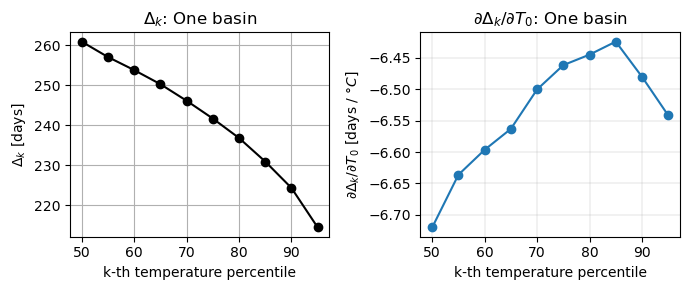

In [55]:
#visualize delta and ddelta/dT0 for a single basin

kk_station = 0 #first basin
kk_station = np.argsort(np.mean(Tmean_mean, axis = -1))[1] #one of the coldest basins

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (7,3))

ax_delta1 = axes[0]
ax_delta2 = axes[1]

ax_delta1.plot(Ts[:-1],t_below_0[kk_station,:-1], marker = 'o', color = 'k')
ax_delta2.plot(Ts[:-1],2*dtp_dT0[kk_station,:-1], marker = 'o')

ax_delta1.set_ylabel('$\Delta_k$ [days]')
ax_delta1.set_xlabel('k-th temperature percentile')
ax_delta1.set_title('$\Delta_k$: One basin')
ax_delta1.grid('True')

ax_delta2.set_ylabel('$\partial \Delta_k / \partial T_0$ [days / $\degree C$]')
ax_delta2.set_xlabel('k-th temperature percentile')
ax_delta2.set_title('$\partial \Delta_k / \partial T_0$: One basin')
ax_delta2.grid('True', linewidth = 0.25)

plt.tight_layout()

In [56]:
#calculate Delta and dDelta_dT0 for space spanning T0 and Ta

N_Ta = 500 #number of values of Ta
N_T0 = 500 #number of values of T0

#initialize
dDelta_dT0 = np.zeros((N_Ta,N_T0)) 
Delta = np.zeros((N_Ta,N_T0))
T0_vec = np.linspace(-12,12,N_T0)
Ta_vec = np.linspace(5,20,N_Ta)

for kk_Ta in range(N_Ta): #for each value of Ta
    for kk_T0 in range(N_T0): #for each value of T0
        dDelta_dT0[kk_Ta,kk_T0] = dDelta_dT0_func(T0_vec[kk_T0],Ta_vec[kk_Ta])
        Delta[kk_Ta,kk_T0] = Delta_func(T0_vec[kk_T0],Ta_vec[kk_Ta])
        

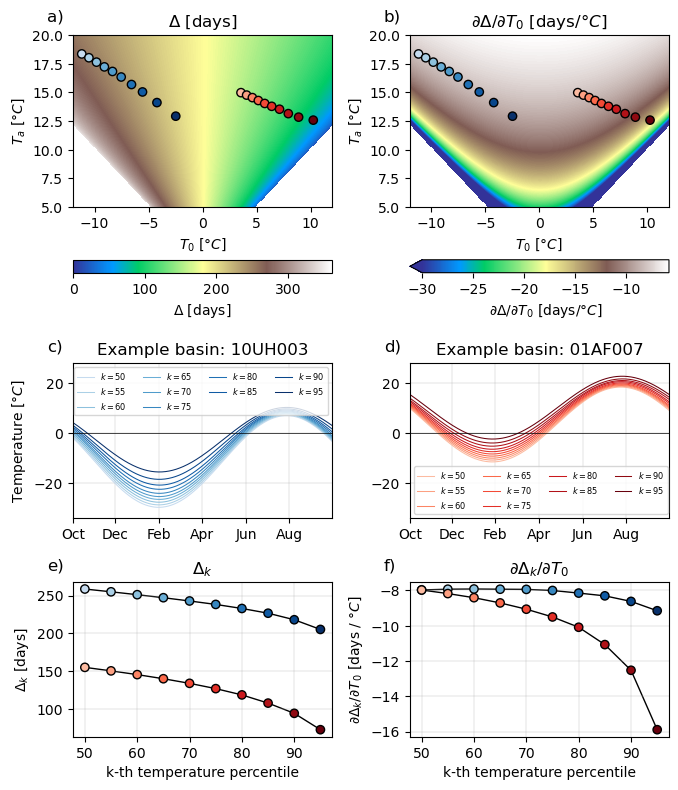

In [57]:
#visualize Delta, dDelta_dT0 and T for different percentiles for two basins

saveIt = 0

nrows = 7
ncols = 2

fs = 12

fig = plt.figure(figsize = (7, 8))
gs = fig.add_gridspec(nrows = nrows, ncols = ncols)

ax0 = fig.add_subplot(gs[:3,0])
ax1 = fig.add_subplot(gs[:3,1])
ax2 = fig.add_subplot(gs[3:5,0])
ax3 = fig.add_subplot(gs[3:5,1])
ax4 = fig.add_subplot(gs[5:,0])
ax5 = fig.add_subplot(gs[5:,1])

##### DELTA

ax = ax0

vmin = 0
vmax = np.nanmax(Delta)

cmap = 'terrain'
extent = [np.min(T0_vec), np.max(T0_vec), np.min(Ta_vec), np.max(Ta_vec)]
im = ax.imshow(Delta, cmap = cmap, extent = extent, aspect = 'auto', origin = 'lower', vmin = vmin, vmax = vmax, )#,norm=SymLogNorm(vmin=vmin, vmax=vmax, linthresh=0.1))
cbar = plt.colorbar(im,ax = ax, orientation = 'horizontal', pad = 0.2)
ax.set_ylabel('$T_a$ [$\degree C$]')
ax.set_xlabel('$T_0$ [$\degree C$]')
ax.set_title('$\Delta$ [days]')
cbar.ax.set_xlabel('$\Delta$ [days]')

##### dDELTA_dT0
ax = ax1

vmin = -30
vmax = np.nanmax(dDelta_dT0)

cmap = 'terrain'
extent = [np.min(T0_vec), np.max(T0_vec), np.min(Ta_vec), np.max(Ta_vec)]
im = ax.imshow(dDelta_dT0, cmap = cmap, extent = extent, aspect = 'auto', origin = 'lower', vmin = vmin, vmax = vmax, )#,norm=SymLogNorm(vmin=vmin, vmax=vmax, linthresh=0.1))
cbar = plt.colorbar(im,ax = ax, extend = 'min', orientation = 'horizontal', pad = 0.2)
ax.set_ylabel('$T_a$ [$\degree C$]')
ax.set_xlabel('$T_0$ [$\degree C$]')
ax.set_title('$\partial \Delta / \partial T_0$ [days$/\degree C$]')
cbar.ax.set_xlabel('$\partial \Delta / \partial T_0$ [days$/\degree C$]')

##### COLDER STATION

cmap = matplotlib.cm.get_cmap('Blues')#'Spectral')
colours = [cmap(kk) for kk in np.linspace(0.25,1,len(Ts)-1)]

kk_station = 857
T0s = np.zeros(len(Ts)-1)
TAs = np.zeros(len(Ts)-1)
Delta_station = np.zeros(len(Ts)-1)
dDelta_station = np.zeros(len(Ts)-1)
for kk_T, T_percentile in enumerate(Ts[:-1]): #for each percentile
    yy = np.array([np.nanpercentile(Tmean[kk_station,day_of_year_wy==day], q = T_percentile) for day in range(365)])
    tt = np.arange(365)
    res = fit_sin(tt,yy) #fit sine
    yy2 = res['fitfunc'](tt)
    TAs[kk_T] = np.abs(res['amp'])
    T0s[kk_T] = np.mean(yy)
    Delta_station[kk_T] = Delta_func(T0s[kk_T],TAs[kk_T])
    dDelta_station[kk_T] = dDelta_dT0_func(T0s[kk_T],TAs[kk_T])
    ax2.plot(tt,yy2, 'k', linewidth = 0.75, c = colours[kk_T], label = '$k={}$'.format(T_percentile))

#add T0 and TA of this basin to other subplots
ax0.scatter(T0s,TAs, edgecolor = 'k', linewidth = 1, c = colours)
ax1.scatter(T0s,TAs, edgecolor = 'k', linewidth = 1, c = colours)
ax4.plot(Ts[:-1],Delta_station, linewidth = 1, c = 'k', zorder = 0)
ax4.scatter(Ts[:-1],Delta_station,edgecolor = 'k', linewidth = 1, c = colours)
ax5.plot(Ts[:-1],dDelta_station, linewidth = 1, c = 'k', zorder = 0)
ax5.scatter(Ts[:-1],dDelta_station,edgecolor = 'k', linewidth = 1, c = colours)
ax2.set_ylabel('Temperature [$\degree C$]')
ax2.legend(ncol=3, fontsize = 7)
ax2.set_title('Example basin: ' + station_IDs[kk_station][7:])

##### WARMER STATION

cmap = matplotlib.cm.get_cmap('Reds')#'Spectral')
colours = [cmap(kk) for kk in np.linspace(0.25,1,len(Ts)-1)]

kk_station = 0
T0s = np.zeros(len(Ts)-1)
TAs = np.zeros(len(Ts)-1)
Delta_station = np.zeros(len(Ts)-1)
dDelta_station = np.zeros(len(Ts)-1)
for kk_T, T_percentile in enumerate(Ts[:-1]): #for each percentile
    yy = np.array([np.nanpercentile(Tmean[kk_station,day_of_year_wy==day], q = T_percentile) for day in range(365)])
    tt = np.arange(365)
    res = fit_sin(tt,yy) #fit sine
    yy2 = res['fitfunc'](tt)
    TAs[kk_T] = np.abs(res['amp'])
    T0s[kk_T] = np.mean(yy)
    Delta_station[kk_T] = Delta_func(T0s[kk_T],TAs[kk_T])
    dDelta_station[kk_T] = dDelta_dT0_func(T0s[kk_T],TAs[kk_T])
    ax3.plot(tt,yy2, 'k', linewidth = 0.75, c = colours[kk_T], label = '$k={}$'.format(T_percentile))
    
#add T0 and TA of this basin to other subplots
ax0.scatter(T0s,TAs, edgecolor = 'k', linewidth = 1, c = colours)
ax1.scatter(T0s,TAs, edgecolor = 'k', linewidth = 1, c = colours)
ax4.plot(Ts[:-1],Delta_station, linewidth = 1, c = 'k', zorder = 0)
ax4.scatter(Ts[:-1],Delta_station,edgecolor = 'k', linewidth = 1, c = colours)
ax5.plot(Ts[:-1],dDelta_station, linewidth = 1, c = 'k', zorder = 0)
ax5.scatter(Ts[:-1],dDelta_station,edgecolor = 'k', linewidth = 1, c = colours)
ax3.legend(ncol=4, fontsize = 6)
ax3.set_title('Example basin: ' + station_IDs[kk_station][7:])

##### DELTA STATIONS

ax4.set_ylabel('$\Delta_k$ [days]')
ax4.set_xlabel('k-th temperature percentile')
ax4.set_title('$\Delta_k$')

ax5.set_ylabel('$\partial \Delta_k / \partial T_0$ [days / $\degree C$]')
ax5.set_xlabel('k-th temperature percentile')
ax5.set_title('$\partial \Delta_k / \partial T_0$')

##### FORMATTING

for ax in [ax2, ax3]:
    axes_dates(ax)
    ax.set_xticks(ax.get_xticks()[::2])
    ax.set_ylim(bottom = -34, top = 28)
    ax.plot([0,364],[0,0], 'k', linewidth = 0.5)
    ax.legend(ncol=4, fontsize = 5.9)

for ax in [ax4,ax5]:
    ax.grid('True', linewidth = 0.25)
    
for kk, ax in enumerate([ax0, ax1, ax2, ax3, ax4,ax5]):
    ax.text(x = -0.1, y = 1.08, s = abc[kk], transform = ax.transAxes, fontsize = fs)
    ax.set_axisbelow(True)

plt.tight_layout()

if saveIt:
    plt.savefig('Figures/Delta_and_dDelta_dT0_function.png', dpi = 300, bbox_inches = 'tight')

plt.show()

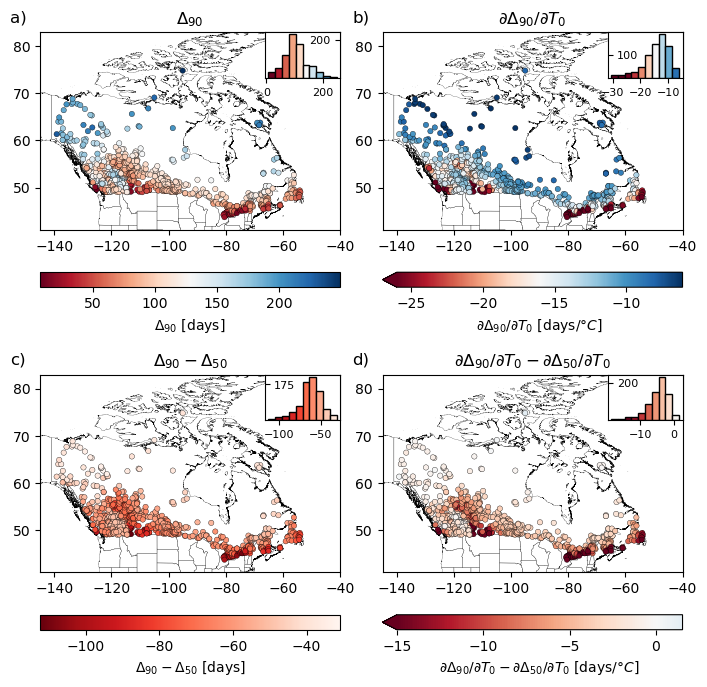

In [58]:
#visualize spatial patterns

saveIt = 0

nrows = 2
ncols = 2

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (3.5*ncols, 3.5*nrows))


##### SPATIAL MAP: DELTA90

ax = axes[0,0]

c1 = t_below_0[:,-3]
vmin = np.nanmin(c1)
cmap = 'RdBu'

# inds_missing = np.argwhere(np.isnan(c1)).squeeze()
s = ax.scatter(lon,lat, c = c1, edgecolor = 'k', linewidth = 0.25, s = 15, label = '$T_{90}< 0\degree C$', vmin = vmin, cmap = cmap)

cbar = fig.colorbar(s, ax = ax, orientation = 'horizontal')
cbar.ax.set_xlabel('$\Delta _{' + str(Ts[-3]) + '}$ [days]')
ax.set_title('$\Delta _{' + str(Ts[-3]) + '}$')

## INSET
position = [0.75,0.77,0.25,0.23]
ax_inset = plt.axes([0,0,1,1], aspect = 'auto')
ip = InsetPosition(ax, position)
ax_inset.set_axes_locator(ip)

vmin = np.nanmin(c1)
vmax = np.nanmax(c1)
mapname = 'RdBu'
cmap = cm.get_cmap(mapname)
norm = matplotlib.colors.Normalize(vmin = vmin, vmax = vmax)
scalarMap = cm.ScalarMappable(norm = norm, cmap = cmap)

n, bins, patches = ax_inset.hist(c1, edgecolor = 'k')
colours = scalarMap.to_rgba(bins)
kk = 0
for patch in patches:
  patch.set_facecolor(colours[kk])
  kk+=1

ax_inset.yaxis.tick_right()
ax_inset.set_frame_on = False
ax_inset.tick_params(labelsize = fs-4)
ax_inset.set_yticks([200])
ax_inset.tick_params(axis="y",direction="in", pad=-22)

##### SPATIAL MAP: dDETLA90_dT0

ax = axes[0,1]

c2 = 2*dtp_dT0[:,-3]
vmin = -30
vmin = -26
vmax = np.nanmax(c2)
cmap = 'Blues_r'
cmap = 'viridis'
cmap = 'RdBu'

# inds_missing = np.argwhere(np.isnan(c2)).squeeze()
s = ax.scatter(lon,lat, c = c2, edgecolor = 'k', linewidth = 0.25, s = 15, label = '$T_{90}< 0\degree C$', vmin = vmin, vmax = vmax, cmap = cmap)

cbar = fig.colorbar(s, ax = ax, orientation = 'horizontal', extend = 'min', )
cbar.ax.set_xlabel('$\partial \Delta _{' + str(Ts[-3]) + '}/\partial T_0$ [days/$\degree C$]')
ax.set_title('$\partial \Delta _{' + str(Ts[-3]) + '}/\partial T_0$')

## INSET

ax_inset = plt.axes([0,0,1,1], aspect = 'auto')
ip = InsetPosition(ax, position)
ax_inset.set_axes_locator(ip)

mapname = 'RdBu'
cmap = cm.get_cmap(mapname)
norm = matplotlib.colors.Normalize(vmin = vmin, vmax = vmax)
scalarMap = cm.ScalarMappable(norm = norm, cmap = cmap)

n, bins, patches = ax_inset.hist(c2[c2>vmin-5], edgecolor = 'k')
colours = scalarMap.to_rgba(bins)
kk = 0
for patch in patches:
  patch.set_facecolor(colours[kk])
  kk+=1

ax_inset.set_frame_on = False
ax_inset.tick_params(labelsize = fs-4)
ax_inset.set_yticks([100])
ax_inset.tick_params(axis="y",direction="in", pad=-22)

##### SPATIAL MAP: MORE EXTREME ANOMALIES HAVE SMALLER DELTA

ax = axes[1,0]

c1 = t_below_0[:,-3] - t_below_0[:,0]
vmin = np.nanmin(c1)
cmap = 'Blues_r'
cmap= 'Reds_r'

# inds_missing = np.argwhere(np.isnan(c1)).squeeze()
s = ax.scatter(lon,lat, c = c1, edgecolor = 'k', linewidth = 0.25, s = 15, label = '$T_{90}< 0\degree C$', vmin = vmin, cmap = cmap)

cbar = fig.colorbar(s, ax = ax, orientation = 'horizontal')
cbar.ax.set_xlabel('$\Delta _{' + str(Ts[-3]) + '} - \Delta _{' + str(Ts[0]) + '}$ [days]')
ax.set_title('$\Delta _{' + str(Ts[-3]) + '} - \Delta _{' + str(Ts[0]) + '}$')

## INSET

ax_inset = plt.axes([0,0,1,1], aspect = 'auto')
ip = InsetPosition(ax, position)
ax_inset.set_axes_locator(ip)

vmax = np.nanmax(c1)
mapname = 'Reds_r'
cmap = cm.get_cmap(mapname)
norm = matplotlib.colors.Normalize(vmin = vmin, vmax = vmax)
scalarMap = cm.ScalarMappable(norm = norm, cmap = cmap)

n, bins, patches = ax_inset.hist(c1, edgecolor = 'k')
colours = scalarMap.to_rgba(bins)
kk = 0
for patch in patches:
  patch.set_facecolor(colours[kk])
  kk+=1

ax_inset.set_frame_on = False
ax_inset.tick_params(labelsize = fs-4)
ax_inset.set_yticks([175])
ax_inset.tick_params(axis="y",direction="in", pad=-22)

##### SPATIAL MAP: MORE EXTREME ANOMALIES HAVE MORE SENSITIVE DELTA

ax = axes[1,1]

c2 = 2*dtp_dT0[:,-3] - 2*dtp_dT0[:,0]
vmin = -15
vmax = np.nanmax(c2)
rdbu_r = cm.get_cmap('RdBu_r',256)
rdbu_r = cm.get_cmap('RdBu',256)
newcolors = rdbu_r(np.linspace(0,0.5 - 0.5*vmax/vmin,265))
newmap = ListedColormap(newcolors)
cmap = newmap

# inds_missing = np.argwhere(np.isnan(c2)).squeeze()
s = ax.scatter(lon,lat, c = c2, edgecolor = 'k', linewidth = 0.25, s = 15, label = '$T_{90}< 0\degree C$', vmin = vmin, vmax = vmax, cmap = cmap)

cbar = fig.colorbar(s, ax = ax, orientation = 'horizontal', extend = 'min')
cbar.ax.set_xlabel('$\partial \Delta _{' + str(Ts[-3]) + '}/\partial T_0 - \partial \Delta _{' + str(Ts[0]) + '}/\partial T_0$ [days/$\degree C$]')
ax.set_title('$\partial \Delta _{' + str(Ts[-3]) + '}/\partial T_0 - \partial \Delta _{' + str(Ts[0]) + '}/\partial T_0$')

## INSET

ax_inset = plt.axes([0,0,1,1], aspect = 'auto')
ip = InsetPosition(ax, position)
ax_inset.set_axes_locator(ip)

mapname = 'Reds_r'
cmap = newmap
norm = matplotlib.colors.Normalize(vmin = vmin, vmax = vmax)
scalarMap = cm.ScalarMappable(norm = norm, cmap = cmap)

n, bins, patches = ax_inset.hist(c2[c2>vmin-4], edgecolor = 'k')
colours = scalarMap.to_rgba(bins)
kk = 0
for patch in patches:
  patch.set_facecolor(colours[kk])
  kk+=1

ax_inset.set_frame_on = False
ax_inset.tick_params(labelsize = fs-4)
ax_inset.set_yticks([200])
ax_inset.tick_params(axis="y",direction="in", pad=-22)

##### FORMATTING
for kk,ax in enumerate(axes.flatten()):
    plot_map(ax)
    ax.set_xlim(left = -145, right = -40)
    ax.set_ylim(bottom = 41, top = 83)
    ax.text(x = -0.1, y = 1.05, s = abc[kk], transform = ax.transAxes, fontsize = fs)
    
plt.tight_layout()

if saveIt:
    plt.savefig('Figures/delta_and_diff_maps3.png', dpi = 300, bbox_inches = 'tight')

# Supplementary

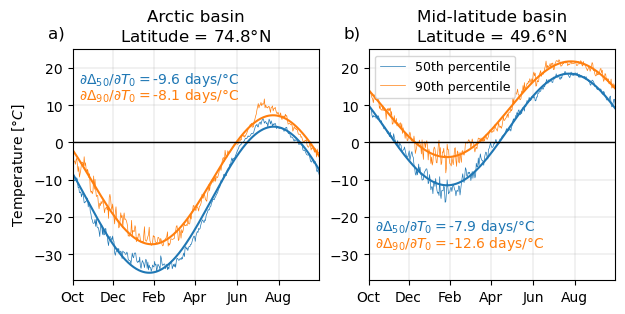

In [59]:
#show 50th and 90th percentile temperature for two basins

saveIt = 0

c2 = 2*dtp_dT0[:,-3] - 2*dtp_dT0[:,0]
ind0 = np.nanargmax(c2)
ind1 = np.nanargmin(c2)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (7,3))

blue = '#1f77b4'
orange = '#ff7f0e'
colors = [blue, orange]

##### first station

ax = axes[0]
var = Tmean[ind0,:]
for kk, q in enumerate([50,90]):

    #observed
    y1 = np.array([np.nanpercentile(var[day_of_year_wy==day], q = q) for day in range(365)])
    ax.plot(y1, linewidth = 0.5, label = str(int(q)) + 'th percentile')
    
    #idealized
    y1,a,b = T_idealized(var,q)
    ax.plot(y1, color = colors[kk], linewidth = 1.5, linestyle = '-')
    ax.text(x = 9, y = 16 - 4.5*kk, s = '$\partial \Delta_{' + str(q) + '} / \partial T_0 = $' + str(np.round(2*b, decimals = 1)) + ' days/$\degree$C', color = colors[kk], fontsize = 10)

ax.set_title('Arctic basin\nLatitude = ' + str(np.round(lat[ind0],decimals = 1)) + '$\degree$N')    
ax.set_ylabel('Temperature [$\degree C$]')
    
##### second station

ax = axes[1]
var = Tmean[0,:]
for kk, q in enumerate([50,90]):

    #observed
    y1 = np.array([np.nanpercentile(var[day_of_year_wy==day], q = q) for day in range(365)])
    ax.plot(y1, linewidth = 0.5, label = str(int(q)) + 'th percentile')
    
    #idealized
    y1,a,b = T_idealized(var,q)
    ax.plot(y1, color = colors[kk], linewidth = 1.5, linestyle = '-')
    ax.text(x = 9, y = -23.5 - 4.5*kk, s = '$\partial \Delta_{' + str(q) + '} / \partial T_0 = $' + str(np.round(2*b, decimals = 1)) + ' days/$\degree$C', color = colors[kk], fontsize = 10)

axes[1].legend(loc = 'upper left', fontsize = 9)
ax.set_title('Mid-latitude basin\nLatitude = ' + str(np.round(lat[ind1],decimals = 1)) + '$\degree$N')
    
for kk,ax in enumerate(axes):
    ax.grid(True, linewidth = 0.25)
    ax.set_axisbelow(True)
    ax.set_xlim(left = 0, right = 364)
    ax.plot([0,364], [0,0], 'k', linewidth = 1)
    ax.set_xticks(first_days_of_month[::2])
    ax.set_xticklabels(months_str[::2])
    ax.set_ylim(bottom = -37, top = 25)
    ax.text(x = -0.1, y = 1.05, s = abc[kk], transform = ax.transAxes, fontsize = fs)
        
if saveIt:
    plt.savefig('Figures/Supplementary/arctic_midlatitude_example_climates.png', dpi = 300, bbox_inches = 'tight')

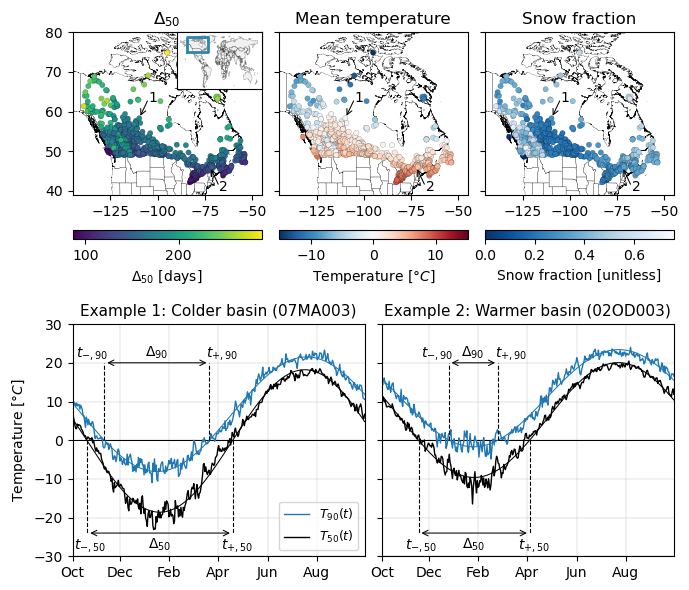

In [63]:
##### STUDY REGION OVERVIEW

saveIt = 0

# kk_stations = [0,800]
# kk_stations = [0,862]
# kk_stations = [0,np.argsort(Tmean_yearly_mean)[50]]
# kk_stations = [np.argsort(Tmean_yearly_mean)[140],np.argsort(Tmean_yearly_mean)[710]]
# kk_stations = [np.argsort(Tmean_yearly_mean)[100],np.argsort(Tmean_yearly_mean)[710]]
kk_stations = [np.argsort(Tmean_yearly_mean)[140],np.argsort(Tmean_yearly_mean)[710]]
# kk_stations = [np.argsort(Tmean_yearly_mean)[140],np.argsort(Tmean_yearly_mean)[705]]
# kk_stations = [np.argsort(Tmean_yearly_mean)[140],np.argsort(Tmean_yearly_mean)[693]]

nrows = 2
ncols = 6
divide_y = 1

fig = plt.figure(figsize = (7, 6))
gs = fig.add_gridspec(nrows = nrows, ncols = ncols)

ax_map_delta = fig.add_subplot(gs[:divide_y,:2])
ax_map_temp = fig.add_subplot(gs[:divide_y,2:4])
ax_map_snow = fig.add_subplot(gs[:divide_y,4:])
ax_temp_1 = fig.add_subplot(gs[divide_y:,:3])
ax_temp_2 = fig.add_subplot(gs[divide_y:,3:])


##### SPATIAL MAP: INSET

rgb_bb = np.array([46, 134, 171]) / 255
canada_east = -50
canada_west = -150
canada_north = 80
canada_south = 40
ax_inset = plt.axes([0,0,1,1], aspect = 'auto')
ip = InsetPosition(ax_map_delta, [0.55,0.65,0.45,0.35])
ax_inset.set_axes_locator(ip)

countries.plot(color="lightgrey", ax = ax_inset, aspect = None, alpha = 0.3, edgecolor = 'k', linewidth = 0.4)
plt.ylim(bottom = -60)

#bounding box
x = [canada_west,canada_west,canada_east,canada_east,canada_west]
y = [canada_south,canada_north,canada_north,canada_south,canada_south]
ax_inset.plot(x,y, color = rgb_bb, linewidth = 2)
ax_inset.tick_params(bottom = False, left = False, labelbottom = False, labelleft = False)


##### SPATIAL MAP: DELTA
size = 15
lw = 0.1

ax = ax_map_delta
cmap = 'viridis'
s = ax.scatter(lon,lat,c = t_below_0[:,0], edgecolor = 'k', linewidth = lw, s = size, cmap = cmap)
cbar = plt.colorbar(s, ax = ax, orientation = 'horizontal')
cbar.ax.set_xlabel('$\Delta_{50}$ [days]')
ax.set_title('$\Delta_{50}$')

##### SPATIAL MAP: TEMPERATURE

ax = ax_map_temp
vmax = np.nanmax(np.abs(Tmean_yearly_mean))
vmin = -vmax
cmap = 'RdBu_r'
s = ax.scatter(lon,lat,c = Tmean_yearly_mean, edgecolor = 'k', linewidth = lw, s = size, vmin = vmin, vmax = vmax, cmap = cmap)
cbar = plt.colorbar(s, ax = ax, orientation = 'horizontal')
cbar.ax.set_xlabel('Temperature [$\degree C$]')
ax.set_title('Mean temperature')
ax.set_yticklabels([])

##### SPATIAL MAP: SNOW FRAC

ax = ax_map_snow
cmap = 'Blues_r'
s = ax.scatter(lon,lat,c = frac_snow, edgecolor = 'k', linewidth = lw, s = size, cmap = cmap)
cbar = plt.colorbar(s, ax = ax, orientation = 'horizontal')
cbar.ax.set_xlabel('Snow fraction [unitless]')
ax.set_title('Snow fraction')
ax.set_yticklabels([])

##### SPATIAL MAPS: FORMATTING

dlat = [5,-5]
dlon = [5,5]

for ax in [ax_map_delta, ax_map_temp, ax_map_snow]:
    plot_map(ax)
    ax.set_xlim(left = -145, right = -45)
    ax.set_ylim(bottom = 39, top = 80)
    
    for kk, kk_station in enumerate(kk_stations):
        ax.annotate('',xy=(lon[kk_station],lat[kk_station]),xytext=(lon[kk_station]+dlon[kk],lat[kk_station]+dlat[kk]),arrowprops=dict(arrowstyle="->", lw = 0.75))
        ax.text(s = str(kk+1), x = lon[kk_station]+dlon[kk], y = lat[kk_station]+dlat[kk]-1)

##### INDIVIDUAL STATIONS: REAL TEMP DATA
Cs = ['C0','C1']

for kk, ax in enumerate([ax_temp_1, ax_temp_2]):

    var = Tmean[kk_stations[kk],:]

    lw = 0.5
    lw = 1

    #observed: 90th percentile
    y1 = np.array([np.nanpercentile(var[day_of_year_wy==day], q = 90) for day in range(365)])
    ax.plot(y1, color = '#1f77b4', linewidth = lw, label = '$T_{90}(t)$')
    
    #observed: median
    y1 = np.array([np.nanpercentile(var[day_of_year_wy==day], q = 50) for day in range(365)])
    ax.plot(y1,'k', linewidth = 1, label = '$T_{50}(t)$')

    #idealized: 90th percentile
    y1,a,b = T_idealized(var,90)
    ax.plot(y1, color = '#1f77b4', linewidth = lw*0.75)

    #90th percentile: text labels
    ax.plot([a,a],[0,20],'k--', linewidth = lw-0.2)
    ax.text(x = a-4, y = 21.5, s = '$t_{+,90}$')
    a1 = np.argmin(y1) - (a - np.argmin(y1))
    ax.plot([a1,a1],[0,20],'k--', linewidth = lw-0.2)
    ax.text(x = a1-35, y = 21.5, s = '$t_{-,90}$')
    a2 = np.argmin(y1)
    ax.text(x = a2-15, y = 21.5, s = '$\Delta_{90}$')
    ax.annotate("", xy=(a, 20), xytext=(a1, 20),arrowprops=dict(arrowstyle="<->", lw = 0.75))

    #idealized: median
    y1,a,b = T_idealized(var,50)
    ax.plot(y1,'k', linewidth = lw*0.75)

    #median: text labels
    ax.plot([a,a],[0,-24],'k--', linewidth = lw-0.2)
    ax.text(x = a-15, y = -28, s = '$t_{+,50}$')
    a1 = np.argmin(y1) - (a - np.argmin(y1))
    ax.plot([a1,a1],[0,-24],'k--', linewidth = lw-0.2)
    ax.text(x = a1-17, y = -28, s = '$t_{-,50}$')
    a2 = np.argmin(y1)
    ax.text(x = a2-15, y = -28, s = '$\Delta_{50}$')
    ax.annotate("", xy=(a, -24), xytext=(a1, -24),arrowprops=dict(arrowstyle="<->", lw = 0.75))

    ##### FORMATTING
    ax.set_xlim(left = 0,right = 364)
    ax.grid(True, linewidth = 0.25)
    ax.set_axisbelow(True)   
    ax.set_xticks(first_days_of_month[::2])
    ax.set_xticklabels(months_str[::2], rotation = 0)
    ax.set_ylim(bottom = -30, top = 30)
    ax.plot([0,364],[0,0],'k', linewidth = 0.75, zorder = 1)
    
ax_temp_1.legend(loc = 'lower right', fontsize = 9)
ax_temp_1.set_ylabel('Temperature [$\degree C$]')
ax_temp_2.set_yticklabels([])
ax_temp_1.set_title('Example 1: Colder basin (' + station_IDs[kk_stations[0]][7:] + ')', fontsize = 11)
ax_temp_2.set_title('Example 2: Warmer basin (' + station_IDs[kk_stations[1]][7:] + ')', fontsize = 11)

plt.tight_layout(w_pad = 0.0)

if saveIt:
    plt.savefig('Figures/study_region_idealized_model2.png', bbox_inches = 'tight', dpi = 400)

plt.show()


In [64]:
for kk in range(2):
    print(station_names[kk_stations[kk]])
    print(lat[kk_stations[kk]])
    print(lon[kk_stations[kk]])

DOUGLAS RIVER NEAR CLUFF LAKE
58.319
-109.7895
NICOLET (RIVIERE) A 5,8 KM EN AVAL DE LA RIVIERE BULSTRODE
46.05639
-72.30639


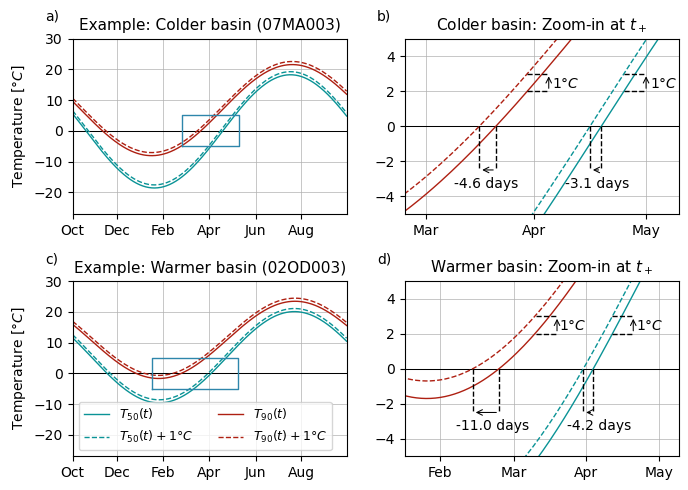

In [65]:
##### CONCEPTUAL OVERVIEW

saveIt = 0

nrows = 2
ncols = 2
divide_y = 1

#colours of normal, warm, and hot event classes
colours = np.array([
    [10, 147, 150],
    [202, 103, 2],
    [174, 32, 18]
])/255

fig = plt.figure(figsize = (7, 5))
gs = fig.add_gridspec(nrows = nrows, ncols = ncols)

ax_temp_1 = fig.add_subplot(gs[0,0])
ax_temp_2 = fig.add_subplot(gs[0,1])
ax_temp_3 = fig.add_subplot(gs[1,0])
ax_temp_4 = fig.add_subplot(gs[1,1])
axes = [ax_temp_1, ax_temp_2, ax_temp_3, ax_temp_4]

##### INDIVIDUAL STATIONS: REAL TEMP DATA

labels = ['$T_{50}(t)$', '$T_{50}(t) + 1\degree C$', '$T_{90}(t)$', '$T_{90}(t) + 1\degree C$']
kk_days = [190,170]

for kk_row in [0,1]:
    
    kk_station = kk_stations[kk_row]
    
    tp50 = (1 / omega[kk_station,0]) * (np.pi + phi[kk_station,0] - np.arcsin((T_0[kk_station,0] - Tm[kk_station])/T_amp[kk_station,0]))
    tp50_new = (1 / omega[kk_station,0]) * (np.pi + phi[kk_station,0] - np.arcsin((T_0[kk_station,0]+1 - Tm[kk_station])/T_amp[kk_station,0]))

    tp90 =     (1 / omega[kk_station,-3]) * (np.pi + phi[kk_station,-3] - np.arcsin((T_0[kk_station,-3] - Tm[kk_station])/T_amp[kk_station,-3]))
    tp90_new = (1 / omega[kk_station,-3]) * (np.pi + phi[kk_station,-3] - np.arcsin((T_0[kk_station,-3]+1 - Tm[kk_station])/T_amp[kk_station,-3]))

    for kk, ax in enumerate(axes[2*kk_row:2*kk_row+2]):

        var = Tmean[kk_station,:]
        lw = 1

        #idealized: median
        y1,a,b = T_idealized(var,50)
        ax.plot(y1, color = colours[0], linewidth = lw, label = labels[0])
        ax.plot(y1 + 1, color = colours[0], linewidth = lw, linestyle = '--', label = labels[1])

        #idealized: 90th percentile
        y2,a,b = T_idealized(var,90)
        ax.plot(y2, color = colours[-1], linewidth = lw, label = labels[2])
        ax.plot(y2+1, color = colours[-1], linewidth = lw, linestyle = '--', label = labels[3])

        ##### FORMATTING
        ax.grid(True, linewidth = 0.5)
        ax.set_axisbelow(True)   
        ax.set_ylim(bottom = -20, top = 30)
        ax.plot([0,364],[0,0],'k', linewidth = 0.75, zorder = 1)
    
        if kk == 0:
            ax.set_xlim(left = 0,right = 364)
            ax.set_xticks(first_days_of_month[::2])
            ax.set_xticklabels(months_str[::2], rotation = 0)
            ax.set_ylim(bottom = -27, top = 30)
            ax.set_ylabel('Temperature [$\degree C$]')
        else:
            ax.set_xticks(first_days_of_month)
            ax.set_xticklabels(months_str, rotation = 0)
            ax.set_ylim(bottom = -5, top = 5)

            ax.plot([tp50,tp50],[0,-2.5], 'k--', linewidth = 1)
            ax.plot([tp50_new,tp50_new],[0,-2.5], 'k--', linewidth = 1)

            ax.plot([tp90,tp90],[0,-2.5], 'k--', linewidth = 1)
            ax.plot([tp90_new,tp90_new],[0,-2.5], 'k--', linewidth = 1)

            ax.annotate("", xy = (tp50, -2.5), xytext = (tp50_new,-2.5), arrowprops=dict(arrowstyle="<-", lw = 0.75))
            ax.annotate("", xy = (tp90, -2.5), xytext = (tp90_new,-2.5), arrowprops=dict(arrowstyle="<-", lw = 0.75))

            ax.text(x = tp90_new-7, y = -3.5, s = str(np.round(tp90_new - tp90, decimals = 1)) + ' days')
            ax.text(x = tp50_new-7, y = -3.5, s = str(np.round(tp50_new - tp50, decimals = 1)) + ' days')
            
        ax.text(x = -0.1, y = 1.1, s = abc[2*kk_row+kk], transform = ax.transAxes, fontsize = fs-2)
            
left1 = 145
right1 = 221
left2 = 105
right2 = 220
x1 = [left1,left1,right1,right1,left1]
y1 = [-5,5,5,-5,-5]
x2 = [left2,left2,right2,right2,left2]
ax_temp_1.plot(x1,y1, color = rgb_bb, linewidth = 1)
ax_temp_3.plot(x2,y1, color = rgb_bb, linewidth = 1)
            
ax_temp_3.legend(ncol=2, fontsize = 9)
ax_temp_2.set_xlim(left = left1,right = right1)
ax_temp_4.set_xlim(left = left2,right = right2)

ax_temp_1.set_title('Example: Colder basin (' + station_IDs[kk_stations[0]][7:] + ')', fontsize = 11)
ax_temp_2.set_title('Colder basin: Zoom-in at $t_+$', fontsize = 11)
ax_temp_3.set_title('Example: Warmer basin (' + station_IDs[kk_stations[1]][7:] + ')', fontsize = 11)
ax_temp_4.set_title('Warmer basin: Zoom-in at $t_+$', fontsize = 11)

ax_temp_2.plot([179,185],[2,2], 'k--', linewidth = 1)
ax_temp_2.plot([179,185],[3,3], 'k--', linewidth = 1)
ax_temp_2.annotate("", xy = (185, 2), xytext = (185,3), arrowprops=dict(arrowstyle="<-", lw = 0.75))
ax_temp_2.text(x = 186,y=2.2,s='$1\degree C$')

ax_temp_2.plot([206,212],[2,2], 'k--', linewidth = 1)
ax_temp_2.plot([206,212],[3,3], 'k--', linewidth = 1)
ax_temp_2.annotate("", xy = (212, 2), xytext = (212,3), arrowprops=dict(arrowstyle="<-", lw = 0.75))
ax_temp_2.text(x = 213,y=2.2,s='$1\degree C$')

ax_temp_4.plot([160,169],[2,2], 'k--', linewidth = 1)
ax_temp_4.plot([160,169],[3,3], 'k--', linewidth = 1)
ax_temp_4.annotate("", xy = (169, 2), xytext = (169,3), arrowprops=dict(arrowstyle="<-", lw = 0.75))
ax_temp_4.text(x = 170,y=2.2,s='$1\degree C$')

ax_temp_4.plot([192,201],[2,2], 'k--', linewidth = 1)
ax_temp_4.plot([192,201],[3,3], 'k--', linewidth = 1)
ax_temp_4.annotate("", xy = (201, 2), xytext = (201,3), arrowprops=dict(arrowstyle="<-", lw = 0.75))
ax_temp_4.text(x = 202,y=2.2,s='$1\degree C$')

plt.tight_layout()

if saveIt:
    plt.savefig('Figures/conceptual_examples.png', bbox_inches = 'tight', dpi = 400)

plt.show()

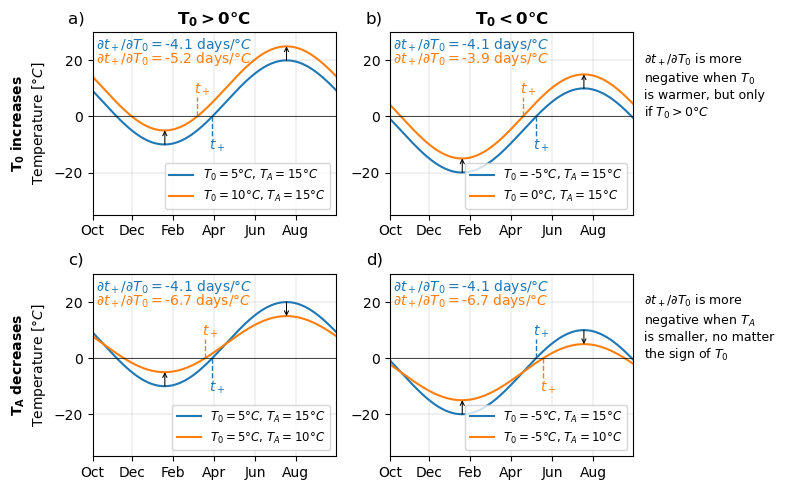

In [66]:
# CONCEPTUAL OVERVIEW

saveIt = 0

nrows = 2
ncols = 2

Cs = ['C0','C1']
labels = ['Case 1', 'Case 2']
points = [-7,7]
points_text = [-12,8]
omega_kk = 365 / (2*np.pi)
omega_kk = 2*np.pi / 365
phi_kk = 0.28

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 2.5*nrows))

##### T0 > 0 AND T0 INCREASES

ax = axes[0,0]
T0s = [5,10]
TA = 15
for kk, T0 in enumerate(T0s):
    T = sine_model(T0,TA)
    dtp_dT0_here = 0.5*dDelta_dT0_func(T0,TA)
    ax.plot(T, label = '$T_0=$' + str(T0) + '$\degree C$, $T_A=$' + str(TA) + '$\degree C$')
    ax.text(x = 5, y = 24-5*kk, s = '$\partial t_+/\partial T_0=$' + str(np.round(dtp_dT0_here,decimals=1)) + ' days/$\degree C$', color = Cs[kk])
    
    tp_kk = (1 / omega_kk) * (np.pi + phi_kk - np.arcsin(T0/TA))
    ax.plot([tp_kk,tp_kk],[0,points[kk]], color = Cs[kk], linewidth = 1, linestyle = '--')
    ax.text(x = tp_kk-5, y = points_text[kk], s = '$t_+$', color = Cs[kk])
    
x1 = np.argmin(T)
x2 = np.argmax(T)
y1 = np.min(T)
y2 = np.max(T)
ax.annotate('', xy = (x1,y1-6), xytext = (x1,y1+1), arrowprops=dict(arrowstyle="<-", lw = 0.75, mutation_scale = 7.5))
ax.annotate('', xy = (x2,y2-6), xytext = (x2,y2+1), arrowprops=dict(arrowstyle="<-", lw = 0.75, mutation_scale = 7.5))
    
ax.legend(fontsize = 8.5, loc = 'lower right')

##### T0 > 0 AND TA DECREASES

ax = axes[1,0]
T0 = 5
TAs = [15, 10]
for kk, TA in enumerate(TAs):
    T = sine_model(T0,TA)
    dtp_dT0_here = 0.5*dDelta_dT0_func(T0,TA)
    ax.plot(T, label = '$T_0=$' + str(T0) + '$\degree C$, $T_A=$' + str(TA) + '$\degree C$')
    ax.text(x = 5, y = 24-5*kk, s = '$\partial t_+/\partial T_0=$' + str(np.round(dtp_dT0_here,decimals=1)) + ' days/$\degree C$', color = Cs[kk])
    
    tp_kk = (1 / omega_kk) * (np.pi + phi_kk - np.arcsin(T0/TA))
    ax.plot([tp_kk,tp_kk],[0,points[kk]], color = Cs[kk], linewidth = 1, linestyle = '--')
    ax.text(x = tp_kk-5, y = points_text[kk], s = '$t_+$', color = Cs[kk])
    
x1 = np.argmin(T)
x2 = np.argmax(T)
y1 = np.min(T)
y2 = np.max(T)+5
ax.annotate('', xy = (x1,y1-6), xytext = (x1,y1+1), arrowprops=dict(arrowstyle="<-", lw = 0.75, mutation_scale = 7.5))
ax.annotate('', xytext = (x2,y2-6), xy = (x2,y2+1), arrowprops=dict(arrowstyle="<-", lw = 0.75, mutation_scale = 7.5))

ax.legend(fontsize = 8.5, loc = 'lower right')

##### T0 < 0 AND T0 INCREASES

ax = axes[0,1]
T0s = [-5,0]
TA = 15
for kk, T0 in enumerate(T0s):
    T = sine_model(T0,TA)
    dtp_dT0_here = 0.5*dDelta_dT0_func(T0,TA)
    ax.plot(T, label = '$T_0=$' + str(T0) + '$\degree C$, $T_A=$' + str(TA) + '$\degree C$')
    ax.text(x = 5, y = 24-5*kk, s = '$\partial t_+/\partial T_0=$' + str(np.round(dtp_dT0_here,decimals=1)) + ' days/$\degree C$', color = Cs[kk])

    tp_kk = (1 / omega_kk) * (np.pi + phi_kk - np.arcsin(T0/TA))
    ax.plot([tp_kk,tp_kk],[0,points[kk]], color = Cs[kk], linewidth = 1, linestyle = '--')
    ax.text(x = tp_kk-5, y = points_text[kk], s = '$t_+$', color = Cs[kk])
    
x1 = np.argmin(T)
x2 = np.argmax(T)
y1 = np.min(T)
y2 = np.max(T)
ax.annotate('', xy = (x1,y1-6), xytext = (x1,y1+1), arrowprops=dict(arrowstyle="<-", lw = 0.75, mutation_scale = 7.5))
ax.annotate('', xy = (x2,y2-6), xytext = (x2,y2+1), arrowprops=dict(arrowstyle="<-", lw = 0.75, mutation_scale = 7.5))
    
ax.legend(fontsize = 8.5, loc = 'lower right')

##### T0 < 0 AND TA DECREASES

ax = axes[1,1]
T0 = -5
TAs = [15,10]
for kk, TA in enumerate(TAs):
    T = sine_model(T0,TA)
    dtp_dT0_here = 0.5*dDelta_dT0_func(T0,TA)
    ax.plot(T, label = '$T_0=$' + str(T0) + '$\degree C$, $T_A=$' + str(TA) + '$\degree C$')
    ax.text(x = 5, y = 24-5*kk, s = '$\partial t_+/\partial T_0=$' + str(np.round(dtp_dT0_here,decimals=1)) + ' days/$\degree C$', color = Cs[kk])
    
    tp_kk = (1 / omega_kk) * (np.pi + phi_kk - np.arcsin(T0/TA))
    ax.plot([tp_kk,tp_kk],[0,points[1-kk]], color = Cs[kk], linewidth = 1, linestyle = '--')
    ax.text(x = tp_kk-5, y = points_text[1-kk], s = '$t_+$', color = Cs[kk])
    
x1 = np.argmin(T)
x2 = np.argmax(T)
y1 = np.min(T)
y2 = np.max(T)+5
ax.annotate('', xy = (x1,y1-6), xytext = (x1,y1+1), arrowprops=dict(arrowstyle="<-", lw = 0.75, mutation_scale = 7.5))
ax.annotate('', xytext = (x2,y2-6), xy = (x2,y2+1), arrowprops=dict(arrowstyle="<-", lw = 0.75, mutation_scale = 7.5))

ax.legend(fontsize = 8.5, loc = 'lower right')

##### FORMATTING

for kk, ax in enumerate(axes.flatten()):
    ax.set_xlim(left = 0,right = 364)
    ax.grid(True, linewidth = 0.25)
    ax.set_axisbelow(True)
    ax.set_xticks(first_days_of_month[::2])
    ax.set_xticklabels(months_str[::2], rotation = 0)
    ax.plot([0,364],[0,0], 'k', linewidth = 0.5)
    ax.set_ylim(bottom = -35, top = 30)
    ax.text(x = -0.1, y = 1.05, s = abc[kk], transform = ax.transAxes, fontsize = fs)
    
axes[0,0].set_title(r'$\bf{T_0>0\degree C}$')
axes[0,1].set_title(r'$\bf{T_0<0\degree C}$')
axes[0,0].set_ylabel(r'$\bf{T_0}$' + ' ' + r'$\bf{increases}$' + '\nTemperature [$\degree C$]')
axes[1,0].set_ylabel(r'$\bf{T_A}$' + ' ' + r'$\bf{decreases}$' + '\nTemperature [$\degree C$]')

axes[0,1].text(x = 380, y = 0, s = '$\partial t_+/\partial T_0$ is more \nnegative when $T_0$ \nis warmer, but only \nif $T_0>0\degree C$', fontsize = 9)
axes[1,1].text(x = 380, y = 0, s = '$\partial t_+/\partial T_0$ is more \nnegative when $T_A$ \nis smaller, no matter \nthe sign of $T_0$', fontsize = 9)

plt.tight_layout()

if saveIt:
    plt.savefig('Figures/conceptual_examples2.png', bbox_inches = 'tight', dpi = 400)
    
plt.show()

In [67]:
print('SNOW FRACTION')
print('Min:  ', str(np.round(np.min(frac_snow), decimals = 2)))
print('Max:  ', str(np.round(np.max(frac_snow), decimals = 2)))
print('Mean: ', str(np.round(np.mean(frac_snow), decimals = 2)))
print('Std:  ', str(np.round(np.std(frac_snow), decimals = 2)))

print('\nMEAN TEMP')
print('Min:  ', str(np.round(np.min(Tmean_yearly_mean), decimals = 2)))
print('Max:  ', str(np.round(np.max(Tmean_yearly_mean), decimals = 2)))
print('Mean: ', str(np.round(np.mean(Tmean_yearly_mean), decimals = 2)))
print('Std:  ', str(np.round(np.std(Tmean_yearly_mean), decimals = 2)))


SNOW FRACTION
Min:   0.0
Max:   0.76
Mean:  0.33
Std:   0.13

MEAN TEMP
Min:   -15.14
Max:   10.1
Mean:  2.43
Std:   3.61


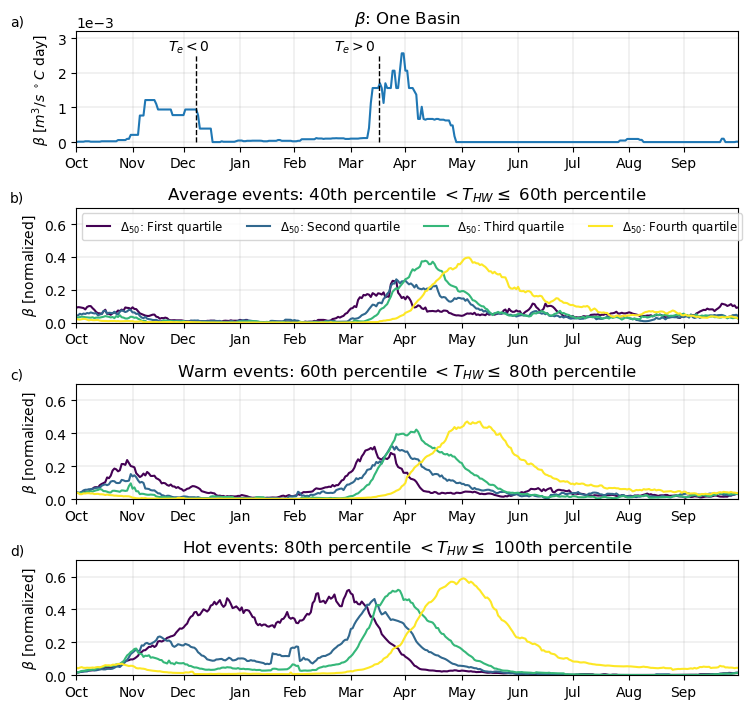

In [81]:
#visualize beta through time for different event classes, aggregated by delta of median temperature

N_subzero = 4

saveIt = 0

nrows = 4
ncols = 1

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (8*ncols, 1.8*nrows))

linestyles = ['-','--']

labels = [
    '$\Delta_{50}$: First quartile',
    '$\Delta_{50}$: Second quartile',
    '$\Delta_{50}$: Third quartile',
    '$\Delta_{50}$: Fourth quartile'
]

title_parts = ['Average events: ', 'Warm events: ', 'Hot events: ']

kk_T_start = [np.argwhere(T_percentiles == 50)[0][0], np.argwhere(T_percentiles == 60)[0][0], np.argwhere(T_percentiles == 80)[0][0]]
kk_T_end = [np.argwhere(T_percentiles == 55)[0][0]+1, np.argwhere(T_percentiles == 75)[0][0]+1, np.argwhere(T_percentiles == 95)[0][0]-1]

for kk_T, ax in enumerate(axes[1:].flatten()[:N_percentile_bins]):
    
    var = beta_station_percentiles_norm[:,kk_T,:]
    
    ## HERE: no data threshold, binned by delta
    p0 = np.nanpercentile(t_below_0[:,0], q = 25)
    p1 = np.nanpercentile(t_below_0[:,0], q = 50)
    p2 = np.nanpercentile(t_below_0[:,0], q = 75)
    
    inds0 = np.argwhere(t_below_0[:,0] < p0).squeeze()
    inds1 = np.argwhere((t_below_0[:,0] < p1) & (t_below_0[:,0] > p0)).squeeze()
    inds2 = np.argwhere((t_below_0[:,0] < p2) & (t_below_0[:,0] > p1)).squeeze()
    inds3 = np.argwhere(t_below_0[:,0] > p2).squeeze()

    inds_set = [inds0,inds1,inds2,inds3]
    N_quartiles = len(inds_set)
    
    for kk_quartile, inds in enumerate(inds_set):

        #color
        vmax = N_quartiles-1
        vmin = 0
        color = matplotlib.cm.get_cmap('viridis')( (kk_quartile - vmin)/(vmax-vmin) )
        
        x1 = np.nanmean(var[inds,:], axis = 0)
        ax.plot(x1, label = labels[kk_quartile], color = color)#, linewidth = 1)#, color = 'k', linestyle = linestyles[kk_T])

        x2 = np.nanpercentile(var[inds,:], axis = 0, q = 25)
        x3 = np.nanpercentile(var[inds,:], axis = 0, q = 75)
        
    axes_dates(ax)
    ax.set_ylabel('$\u03B2$ [normalized]')
        
    title = title_parts[kk_T] + str([40,60,80][kk_T]) + 'th percentile $< T_{HW}\leq$ ' + str([60,80,100][kk_T]) + 'th percentile'
    ax.set_title(title)
    
    ax.set_ylim(bottom = -0.0, top = 0.7)
    
axes[1].legend(loc = 'upper left', fontsize = 8.5, ncols = 4)


##### SINGLE EXAMPLE OF BETA
    
fs = 10

ax = axes[0]

kk_station = 2
kk_T = 2
# ax.plot(dQdT_all[kk_station,:])
ax.plot(beta_station_percentiles[kk_station,kk_T,:])

#label times
t1 = 30
t2 = 75
t3 = 160
t4 = 209
yy = 0.00265

t2 = np.mean(tm[kk_station,6:10])
t3 = np.mean(tp[kk_station,6:10])

lw = 1

ax.plot([t2,t2],[0,0.95*yy], 'k--', linewidth = lw)
ax.plot([t3,t3],[0,0.95*yy], 'k--', linewidth = lw)

ax.text(x = t2-15, y = 1.0*yy, s = '$T_e < 0$')
ax.text(x = t3-25, y = 1.0*yy, s = '$T_e > 0$')

ax.set_title(label = '$\u03B2$: One Basin')
ax.set_ylim(top = 0.0032)
ax.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0.001))
ax.set_ylabel('$\u03B2$ [$m^3 / s$ $^\circ C$ day]', fontsize = fs)
axes_dates(ax)

for kk, ax in enumerate(axes):
    ax.text(x = -0.1, y = 1.05, s = abc[kk], transform = ax.transAxes, fontsize = fs)

plt.tight_layout()

if saveIt:
    plt.savefig('Figures/Supplementary/beta_by_delta_and_temp_percentile_2.png', dpi = 300, bbox_inches = 'tight')

plt.show()

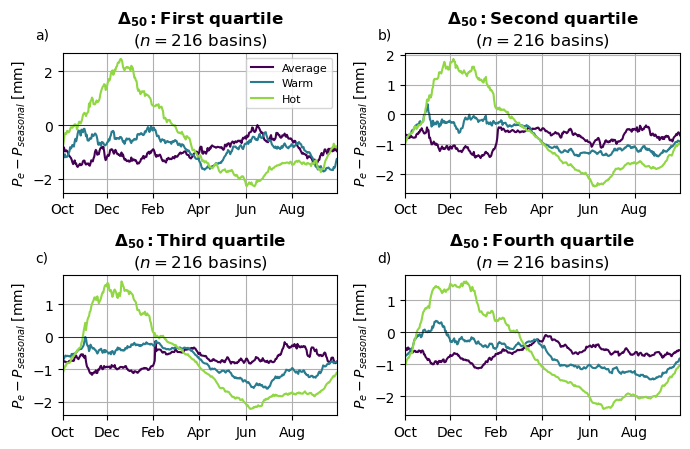

In [93]:
#visualize P_HW - P_seasonal across snow classes for different percentiles

saveIt = 0

nrows = 2
ncols = 2

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (3.5*ncols, 2.3*nrows))

linestyles = ['-','--']

title_parts = ['Average', 'Warm', 'Hot']
labels = [r'$\bf{\Delta_{50}}:$' + r'$\bf{First}$' + ' ' + r'$\bf{quartile}$',
          r'$\bf{\Delta_{50}}:$' + r'$\bf{Second}$' + ' ' + r'$\bf{quartile}$',
          r'$\bf{\Delta_{50}}:$' + r'$\bf{Third}$' + ' ' + r'$\bf{quartile}$',
          r'$\bf{\Delta_{50}}:$' + r'$\bf{Fourth}$' + ' ' + r'$\bf{quartile}$']

for kk_ax, ax in enumerate(axes.flatten()):
    
    inds = inds_set[kk_ax]

    var = Pmean_hw_rolling[inds,:] - np.expand_dims(Pmean_smooth[inds,:], axis = 1)
    
    for kk_T, percentile in enumerate([40,60,80]):

        #color
        vmax = np.nanmax([40,60,80])*1.1
        vmin = np.nanmin([40,60,80])
        color = matplotlib.cm.get_cmap('viridis')( (percentile - vmin)/(vmax-vmin) )
    
        label = str(percentile) + 'th percentile $< T_{e}\leq$ ' + str(percentile+20) + 'th percentile'
        label = title_parts[kk_T]
    
        x1 = np.nanmean(var[:,kk_T,:], axis = 0)
        ax.plot(x1, label = label, color = color)

        x2 = np.nanpercentile(var[:,kk_T,:], axis = 0, q = 25)
        x3 = np.nanpercentile(var[:,kk_T,:], axis = 0, q = 75)
        
    ax.set_xticks(first_days_of_month[::2])
    ax.set_xticklabels(months_str[::2])
    ax.grid(True)
    ax.set_axisbelow(True)
    ax.set_xlim(left = 0, right = 364)
    ax.set_ylabel('$P_{e} - P_{seasonal}$ [mm]')
    ax.plot([0,364],[0,0],'k', linewidth = 0.5)
        
    title = labels[kk_ax] + '\n($n=$' + str(int(len(inds_set[kk_ax]))) + ' basins)'
    ax.set_title(title)
    ax.text(x = -0.1, y = 1.1, s = abc[kk_ax], transform = ax.transAxes, fontsize = fs)
    
axes[0,0].legend(fontsize = 8)

plt.tight_layout()

if saveIt:
    plt.savefig('Figures/Supplementary/Phw_Pseasonal_by_delta_percentile.png', dpi = 300, bbox_inches = 'tight')

plt.show()